In [ ]:
!pip install pydub

In [ ]:
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
!pip install pycryptodome

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.2 MB/s eta 0:00:00


In [ ]:
import os

# Paths
video_file_path = '/content/sample_data/input.mp4'  # Original video
audio_file_path = '/content/sample_data/audio/audio.wav'  # Extracted audio
muted_video_path = '/content/sample_data/muted_video.mp4'  # Muted video

# Extract audio (no compression, preserve original codec if possible)
os.system(f'ffmpeg -i "{video_file_path}" -q:a 0 -map a "{audio_file_path}"')
# os.system(f'ffmpeg -i "{video_file_path}" -vn -acodec copy "{audio_file_path}"')
print(f"Audio extracted (lossless) and saved at: {audio_file_path}")

# Create muted video (copy video stream only, remove audio)
os.system(f'ffmpeg -i "{video_file_path}" -c copy -an "{muted_video_path}"')
print(f"Muted video (lossless) saved at: {muted_video_path}")


Audio extracted (lossless) and saved at: /content/sample_data/audio/audio.wav
Muted video (lossless) saved at: /content/sample_data/muted_video.mp4


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Inputs
model_folder = "/content/sample_data/model"
video_path = "/content/sample_data/muted_video.mp4"

# Load model and scaler
model = keras.models.load_model(os.path.join(model_folder, "dnn_model.h5"),
                                custom_objects={"mse": keras.losses.MeanSquaredError()})
scaler_mean = np.load(os.path.join(model_folder, "scaler.npy"))
scaler_std = np.load(os.path.join(model_folder, "scaler_std.npy"))
scaler = StandardScaler()
scaler.mean_ = scaler_mean
scaler.scale_ = scaler_std

# Feature extraction function
def extract_features(frame, frame_index):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    contrast = np.std(gray)
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist /= hist.sum()
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.sum(edges) / (frame.shape[0] * frame.shape[1])
    pixels = frame.reshape((-1, 3)).astype(np.float32)
    _, labels, _ = cv2.kmeans(pixels, 2, None,
                              (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0),
                              10, cv2.KMEANS_RANDOM_CENTERS)
    color_ratio = np.max(np.bincount(labels.flatten())) / len(labels)
    dct = cv2.dct(np.float32(gray) / 255.0)
    dct_energy = np.sum(np.abs(dct[:10, :10]))
    frame_diff = np.abs(cv2.absdiff(gray, cv2.blur(gray, (5, 5)))).mean()

    return [frame_index, laplacian_var, contrast, entropy, edge_density, color_ratio, dct_energy, frame_diff]

# Process video
cap = cv2.VideoCapture(video_path)
frame_index = 0
features_list = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    if frame_index % 5 == 0:
        features = extract_features(frame, frame_index)
        if features:
            features_list.append(features)
    frame_index += 1
cap.release()

if not features_list:
    print("❌ No valid frames extracted!")
    exit()

# Convert to DataFrame
df = pd.DataFrame(features_list, columns=["Frame Index", "Blurriness", "Contrast", "Entropy", "Edge Density", "Color Ratio", "DCT Energy", "Frame Difference"])
X_test = scaler.transform(df.iloc[:, 1:].values)

# Predict using the trained model
df["Predicted Unsuitability Score"] = model.predict(X_test)

# Save predictions
csv_path = "/content/sample_data/InfoOfSecretText/predictions.csv"
df.to_csv(csv_path, index=False)
print(f"📄 Saved predictions: {csv_path}")

# Select 5 most unsuitable frames
selected_frames = df.nlargest(5, "Predicted Unsuitability Score")["Frame Index"].tolist()
frame_indices_str = ",".join(map(str, selected_frames))

# Save frame indices to metadata file
metadata_path = "/content/sample_data/InfoOfSecretText/metadata.txt"
with open(metadata_path, "w") as f:
    f.write(frame_indices_str)

print(f"✅ Processed video. Frame indices saved in '{metadata_path}'")
# Ensure the directory for frames exists
frames_dir = "/content/sample_data/frames_folder"
os.makedirs(frames_dir, exist_ok=True)

# Save selected frames as images
cap = cv2.VideoCapture(video_path)
for frame_idx in selected_frames:
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    if ret:
        frame_filename = os.path.join(frames_dir, f"frame_{frame_idx}.png")
        cv2.imwrite(frame_filename, frame)
cap.release()

print(f"🖼️ Frames saved in '{frames_dir}'")

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
📄 Saved predictions: /content/sample_data/InfoOfSecretText/predictions.csv
✅ Processed video. Frame indices saved in '/content/sample_data/InfoOfSecretText/metadata.txt'
🖼️ Frames saved in '/content/sample_data/frames_folder'


In [ ]:
import os
import base64
import hashlib
import json
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.Util.Padding import pad, unpad

# Define directories
WORKING_DIR = "/content/sample_data/"
KEYS_DIR = os.path.join(WORKING_DIR, "keys/")
ENCRYPTED_DATA_DIR = os.path.join(WORKING_DIR, "encrypted_data/")

# Ensure directories exist
os.makedirs(KEYS_DIR, exist_ok=True)
os.makedirs(ENCRYPTED_DATA_DIR, exist_ok=True)

# **1. Generate AES Key (256-bit)**
aes_key = os.urandom(32)  # 256-bit key
aes_key_bin_path = os.path.join(KEYS_DIR, "aes_key.bin")
aes_key_txt_path = os.path.join(KEYS_DIR, "aes_key.txt")

# Save AES key in binary
with open(aes_key_bin_path, "wb") as f:
    f.write(aes_key)

# Save AES key in Base64 format (text)
with open(aes_key_txt_path, "w") as f:
    f.write(base64.b64encode(aes_key).decode())

print(f"🔑 AES Key saved at: {aes_key_bin_path}")
print(f"📜 AES Key (Base64) saved at: {aes_key_txt_path}")

# **2. Generate RSA Key Pair (1024-bit)**
rsa_key = RSA.generate(1024)
private_key_path = os.path.join(KEYS_DIR, "private_key.pem")
public_key_path = os.path.join(KEYS_DIR, "public_key.pem")

with open(private_key_path, "wb") as f:
    f.write(rsa_key.export_key())
with open(public_key_path, "wb") as f:
    f.write(rsa_key.publickey().export_key())

print(f"🔐 RSA Private Key saved at: {private_key_path}")
print(f"📜 RSA Public Key saved at: {public_key_path}")

# **3. Encrypt AES Key using RSA Public Key**
public_key = RSA.import_key(open(public_key_path).read())
cipher_rsa = PKCS1_OAEP.new(public_key)
encrypted_aes_key = cipher_rsa.encrypt(aes_key)

# Save encrypted AES key in binary & text formats
encrypted_aes_key_bin_path = os.path.join(KEYS_DIR, "encrypted_aes_key.bin")
encrypted_aes_key_txt_path = os.path.join(KEYS_DIR, "encrypted_aes_key.txt")

with open(encrypted_aes_key_bin_path, "wb") as f:
    f.write(encrypted_aes_key)
with open(encrypted_aes_key_txt_path, "w") as f:
    f.write(base64.b64encode(encrypted_aes_key).decode())

print(f"🔏 AES Key encrypted and saved as binary: {encrypted_aes_key_bin_path}")
print(f"📜 AES Key encrypted and saved as text (Base64): {encrypted_aes_key_txt_path}")

# **4. Read and Encrypt Secret Text File**
secret_text_path = os.path.join(WORKING_DIR, "secret_text.txt")
with open(secret_text_path, "r") as f:
    secret_text = f.read().strip()

# Encrypt using AES-CBC
iv = os.urandom(16)
cipher_aes = AES.new(aes_key, AES.MODE_CBC, iv)
cipher_text = iv + cipher_aes.encrypt(pad(secret_text.encode(), AES.block_size))

# Save encrypted text in binary & text formats
encrypted_text_bin_path = os.path.join(ENCRYPTED_DATA_DIR, "encrypted_text.bin")
encrypted_text_txt_path = os.path.join(ENCRYPTED_DATA_DIR, "encrypted_text.txt")

with open(encrypted_text_bin_path, "wb") as f:
    f.write(cipher_text)
with open(encrypted_text_txt_path, "w") as f:
    f.write(base64.b64encode(cipher_text).decode())

print(f"📝 Secret text encrypted and saved in binary: {encrypted_text_bin_path}")
print(f"📄 Secret text encrypted and saved in text format: {encrypted_text_txt_path}")

# **5. Generate Hybrid Hash (MD5 → SHA-256)**
md5_hash = hashlib.md5(secret_text.encode()).hexdigest()
final_hash = hashlib.sha256(md5_hash.encode()).hexdigest()

hash_path = os.path.join(ENCRYPTED_DATA_DIR, "hash_value.txt")
with open(hash_path, "w") as f:
    f.write(final_hash)

print(f"🔗 Hash value saved at: {hash_path}")

# # **6. Store Metadata**
# metadata = {
#     "original_text_size": len(secret_text),
#     "aes_key_size": len(aes_key) * 8,
#     "rsa_key_size": rsa_key.size_in_bits(),
#     "hash": final_hash,
# }

# metadata_path = os.path.join(ENCRYPTED_DATA_DIR, "metadata.json")
# with open(metadata_path, "w") as f:
#     json.dump(metadata, f, indent=4)

# print(f"📊 Metadata saved at: {metadata_path}")

# # **7. Decryption Verification**
# # Load private key
# private_key = RSA.import_key(open(private_key_path).read())
# cipher_rsa = PKCS1_OAEP.new(private_key)

# # Decrypt AES Key
# decrypted_aes_key = cipher_rsa.decrypt(encrypted_aes_key)
# assert decrypted_aes_key == aes_key, "❌ AES Key decryption failed!"

# # Decrypt Secret Text
# iv = cipher_text[:16]  # Extract IV
# encrypted_data = cipher_text[16:]
# cipher_aes = AES.new(decrypted_aes_key, AES.MODE_CBC, iv)
# decrypted_text = unpad(cipher_aes.decrypt(encrypted_data), AES.block_size).decode()

# assert decrypted_text == secret_text, "❌ Decryption mismatch!"
# print("✅ Encryption & Decryption verified successfully!")


🔑 AES Key saved at: /content/sample_data/keys/aes_key.bin
📜 AES Key (Base64) saved at: /content/sample_data/keys/aes_key.txt
🔐 RSA Private Key saved at: /content/sample_data/keys/private_key.pem
📜 RSA Public Key saved at: /content/sample_data/keys/public_key.pem
🔏 AES Key encrypted and saved as binary: /content/sample_data/keys/encrypted_aes_key.bin
📜 AES Key encrypted and saved as text (Base64): /content/sample_data/keys/encrypted_aes_key.txt
📝 Secret text encrypted and saved in binary: /content/sample_data/encrypted_data/encrypted_text.bin
📄 Secret text encrypted and saved in text format: /content/sample_data/encrypted_data/encrypted_text.txt
🔗 Hash value saved at: /content/sample_data/encrypted_data/hash_value.txt


In [ ]:
!pip install imageio[ffmpeg] ffmpeg-python

In [ ]:
import cv2
import os
import re

# === Working Directories ===
WORKING_DIR = "/content/sample_data/"
ENCRYPTED_TEXT_PATH = WORKING_DIR + "encrypted_data/encrypted_text.txt"
HASH_VALUE_PATH = WORKING_DIR + "encrypted_data/hash_value.txt"
FRAME_FOLDER = WORKING_DIR + "frames_folder/"
STEGO_OUTPUT_DIR = WORKING_DIR + "stego_frames/"
METADATA_PATH = WORKING_DIR + "InfoOfSecretText/metadata.txt"

# Ensure output directory exists
os.makedirs(STEGO_OUTPUT_DIR, exist_ok=True)

# Convert text to binary
def text_to_binary(text):
    return ''.join(format(ord(char), '08b') for char in text)

# Embed data in LSB
def embed_data(image_path, output_path, binary_message, text_part):
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error: Image {image_path} not found or could not be loaded!")
        return False

    height, width, channels = img.shape
    total_pixels = height * width * 3

    if len(binary_message) > total_pixels:
        print(f"❌ Error: Message too large to fit in {image_path}!")
        return False

    flat_img = img.flatten()
    for i in range(len(binary_message)):
        flat_img[i] = (flat_img[i] & 0xFE) | int(binary_message[i])

    stego_img = flat_img.reshape((height, width, channels))
    cv2.imwrite(output_path, stego_img)

    print(f"✅ Embedded into {output_path} (Original Frame: {os.path.basename(image_path)})")
    print(f"   → Embedded Data: \"{text_part}\"")
    print("   ----------------------------------------------------")

    return True

# Read metadata file to get frame indexes
def get_frame_indexes_from_metadata(metadata_file):
    with open(metadata_file, 'r') as f:
        content = f.read().strip()
    return [int(i.strip()) for i in content.split(',') if i.strip().isdigit()]

# Split encrypted text into 4 equal parts
def split_text_into_4_parts(text):
    chunk_size = len(text) // 4
    remainder = len(text) % 4

    parts = []
    start = 0
    for i in range(4):
        end = start + chunk_size + (1 if i < remainder else 0)
        parts.append(text[start:end])
        start = end
    return parts

if __name__ == "__main__":
    # Step 1: Get frame indexes from metadata
    frame_indexes = get_frame_indexes_from_metadata(METADATA_PATH)

    if len(frame_indexes) < 5:
        print(f"❌ Error: Metadata must contain at least 5 frame indexes. Found: {len(frame_indexes)}")
        exit()

    print(f"✅ Frame indexes found in metadata: {frame_indexes}")

    # Step 2: Read encrypted text and hash
    with open(ENCRYPTED_TEXT_PATH, "r") as f:
        encrypted_text = f.read().strip()

    with open(HASH_VALUE_PATH, "r") as f:
        hash_value_text = f.read().strip()

    # Step 3: Split encrypted text into 4 parts
    split_parts = split_text_into_4_parts(encrypted_text)

    print("\n🔹 Starting Embedding Process 🔹\n")

    # Step 4: Embed into corresponding frames
    for i in range(5):
        frame_index = frame_indexes[i]
        image_filename = f"frame_{frame_index}.png"
        image_path = os.path.join(FRAME_FOLDER, image_filename)
        output_path = os.path.join(STEGO_OUTPUT_DIR, f"stego_frame_{frame_index}.png")

        text_part = split_parts[i] if i < 4 else hash_value_text
        binary_message = text_to_binary(text_part)
        embed_data(image_path, output_path, binary_message, text_part)

    print("\n✅ All stego images saved successfully in:", STEGO_OUTPUT_DIR)


✅ Frame indexes found in metadata: [0, 5, 10, 15, 50]

🔹 Starting Embedding Process 🔹

✅ Embedded into /content/sample_data/stego_frames/stego_frame_0.png (Original Frame: frame_0.png)
   → Embedded Data: "AShqOO/fQV1WXr2nEheOvNFc6ugP7aEr1a63WQ0m/PvfAJF/bOzZfLbGcCZHQ/5QhV9HF2Z66GONejNAHrEY85dsmVrtl+rLmpbZsuKFNk2b3pr0UghWbExvh4ZObjywG095n8Nr3peE5fswuPRRL1IqWrnd0pYhwCLrwllB5Y9ZxcOFLerOwC6lIP0HPvPDmPdpBnu1ZmqnA25YnWu6c06sShv5hS4w2KIgooBlHwGjyNFSP7V7tEphGCVTgAvsJF74sVVoRFbSnJwAHAoa81D4/HyZVERVCgs7WQaYgPD3xLaXdwH3ZoszdWqoVf6I62/A1maWdt/vSIc4PU4duH3T1pM0AgR9xOo0FQx1IayAkUlXGCZZ4YY5n6G2uWzEDzUwazl0hG27L2ji80z2QgaCHfDMak+ChazAm6G4K151yk5kTZvYGgGVzfpPr4/cjY5oq1aEuCi5ZoFmeQnxFdoG3KJyvM+nGaBVhOYjhvXuNNytirlkHEBSEfGRKFLOmueJzcutaajm5xdiBjEZhLIIxhJD2um2vugekbarzBsmDUUX126r7wdw3ZYapWQsZObikhD2QpsTTATJsFzCzZm1JK/OhvDoeLopuevJs1EheDeocLxCbtVilivTKRHyTaWU61g+MdO4hpm2WOoNvkwqMYz7NPlgvSnfYoQZXwM3XCLHx23NyWhjuvrPn7xzHnSlZnijIO3yTksgvLHsl9NmQ7Ldf6BeBdD80OQBbojReICTJvWxAsf/OsnV+7mDiYLePoJBZnoY06Iqlc2IBNEZSm

In [ ]:
import os
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from math import log10

def calculate_mse(imageA, imageB):
    return np.mean((imageA.astype("float") - imageB.astype("float")) ** 2)

def calculate_psnr(imageA, imageB):
    mse = calculate_mse(imageA, imageB)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * log10(max_pixel / np.sqrt(mse))

def get_file_size_kb(path):
    return os.path.getsize(path) / 1024  # size in KB

def compare_frame_pairs(original_folder, stego_folder):
    print(f"{'Index':<10}{'PSNR (dB)':<12}{'SSIM':<12}  {'MSE':<20}{'Orig Size(KB)':<15}{'Stego Size(KB)':<15}")
    print("-" * 85)

    for filename in os.listdir(original_folder):
        if filename.startswith("frame_") and filename.endswith(".png"):
            index = filename.replace("frame_", "").replace(".png", "")
            original_path = os.path.join(original_folder, filename)
            stego_filename = f"stego_frame_{index}.png"
            stego_path = os.path.join(stego_folder, stego_filename)

            if not os.path.exists(stego_path):
                print(f"{index:<10}{'Missing stego frame':<75}")
                continue

            original = cv2.imread(original_path)
            stego = cv2.imread(stego_path)

            original_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
            stego_gray = cv2.cvtColor(stego, cv2.COLOR_BGR2GRAY)

            psnr_val = calculate_psnr(original_gray, stego_gray)
            ssim_val, _ = ssim(original_gray, stego_gray, data_range=255, full=True)
            mse_val = calculate_mse(original_gray, stego_gray)
            orig_size_kb = get_file_size_kb(original_path)
            stego_size_kb = get_file_size_kb(stego_path)

            print(f"{index:<10}{psnr_val:<12.2f}{ssim_val:<12.10f}  {mse_val:<20.10f}{orig_size_kb:<15.2f}{stego_size_kb:<15.2f}")

# === Example usage ===
compare_frame_pairs(
    original_folder="/content/sample_data/frames_folder",
    stego_folder="/content/sample_data/stego_frames"
)


Index     PSNR (dB)   SSIM          MSE                 Orig Size(KB)  Stego Size(KB) 
-------------------------------------------------------------------------------------
0         74.17       0.9999991095  0.0024871826        784.78         787.27         
5         74.37       0.9999991309  0.0023786757        790.96         793.50         
10        74.20       0.9999990882  0.0024719238        802.79         805.36         
15        74.12       0.9999990223  0.0025177002        817.32         819.56         
50        85.23       0.9999999988  0.0001949734        872.62         872.87         


In [ ]:
import cv2
import os

def calculate_histogram_diff(original_img, stego_img):
    # Convert both to grayscale
    original_gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
    stego_gray = cv2.cvtColor(stego_img, cv2.COLOR_BGR2GRAY)

    # Calculate histograms
    hist_original = cv2.calcHist([original_gray], [0], None, [256], [0, 256])
    hist_stego = cv2.calcHist([stego_gray], [0], None, [256], [0, 256])

    # Normalize histograms
    cv2.normalize(hist_original, hist_original)
    cv2.normalize(hist_stego, hist_stego)

    # Calculate histogram distances
    correlation = cv2.compareHist(hist_original, hist_stego, cv2.HISTCMP_CORREL)
    chi_square = cv2.compareHist(hist_original, hist_stego, cv2.HISTCMP_CHISQR)
    intersection = cv2.compareHist(hist_original, hist_stego, cv2.HISTCMP_INTERSECT)
    bhattacharyya = cv2.compareHist(hist_original, hist_stego, cv2.HISTCMP_BHATTACHARYYA)

    return correlation, chi_square, intersection, bhattacharyya

def compare_histograms(original_folder, stego_folder):
    print(f"{'Index':<10}{'Corr':<10}{'ChiSq':<10}{'Intersec':<12}{'Bhatt':<10}")
    print("-" * 55)

    for filename in os.listdir(original_folder):
        if filename.startswith("frame_") and filename.endswith(".png"):
            index = filename.replace("frame_", "").replace(".png", "")
            original_path = os.path.join(original_folder, filename)
            stego_filename = f"stego_frame_{index}.png"
            stego_path = os.path.join(stego_folder, stego_filename)

            if not os.path.exists(stego_path):
                print(f"{index:<10}{'Missing stego frame':<45}")
                continue

            original = cv2.imread(original_path)
            stego = cv2.imread(stego_path)

            corr, chi, inter, bhatt = calculate_histogram_diff(original, stego)
            print(f"{index:<10}{corr:<10.3f}{chi:<10.3f}{inter:<12.3f}{bhatt:<10.3f}")

# === Example usage ===
compare_histograms(
    original_folder="/content/sample_data/frames_folder",
    stego_folder="/content/sample_data/stego_frames"
)


Index     Corr      ChiSq     Intersec    Bhatt     
-------------------------------------------------------
0         0.999     0.016     11.173      0.012     
5         0.999     0.012     11.222      0.011     
10        1.000     0.010     11.210      0.010     
15        1.000     0.008     11.356      0.009     
50        1.000     0.000     11.832      0.001     


In [ ]:
import os

# Define directories
WORKING_DIR = "/content/sample_data/"
INFO_DIR = os.path.join(WORKING_DIR, "InfoOfSecretText/")
ENCRYPTED_DATA_DIR = os.path.join(WORKING_DIR, "encrypted_data/")

# Ensure directories exist
os.makedirs(INFO_DIR, exist_ok=True)
os.makedirs(ENCRYPTED_DATA_DIR, exist_ok=True)

# Read metadata and encrypted text
metadata_path = os.path.join(INFO_DIR, "metadata.txt")
encrypted_text_path = os.path.join(ENCRYPTED_DATA_DIR, "encrypted_text.txt")

with open(metadata_path, "r") as f:
    metadata_content = f.read().strip()
with open(encrypted_text_path, "r") as f:
    encrypted_text_content = f.read().strip()

encrypted_text_length = len(encrypted_text_content)
info_file_content = f"{metadata_content}|{encrypted_text_length}"

# Save info.txt
info_file_path = os.path.join(ENCRYPTED_DATA_DIR, "info.txt")
with open(info_file_path, "w") as f:
    f.write(info_file_content)

print(f"✅ info.txt created successfully at: {info_file_path}")

✅ info.txt created successfully at: /content/sample_data/encrypted_data/info.txt


In [ ]:
import os
import cv2

# === CONFIG ===
STEGO_INPUT_DIR = "/content/sample_data/output_extracted_frames"
METADATA_PATH = "/content/sample_data/encrypted_data/info.txt"
OUTPUT_FOLDER = "/content/sample_data/extracted_text_parts/"

# Ensure output directory exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Convert binary to string
def binary_to_text(binary_str):
    chars = [binary_str[i:i+8] for i in range(0, len(binary_str), 8)]
    return ''.join(chr(int(char, 2)) for char in chars)

# Extract LSB binary data from image
def extract_binary_from_image(image_path, bit_length):
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error reading image: {image_path}")
        return ""

    flat = img.flatten()
    bits = [str(flat[i] & 1) for i in range(bit_length)]
    return ''.join(bits)

# Parse metadata line like "18,29,17,39,176|320"
def parse_metadata_line(line):
    print(f"[📄] Metadata line read: {line.strip()}")
    if '|' not in line:
        raise ValueError("❌ Metadata format is incorrect. Expected format: 'idx1,idx2,idx3,idx4,idx5|length'")

    frames_part, total_len = line.strip().split('|')
    indexes = [int(i.strip()) for i in frames_part.split(',')]

    if len(indexes) != 5:
        raise ValueError("❌ Metadata must contain exactly 5 frame indexes.")

    return indexes, int(total_len)

# === Main Decoding ===
with open(METADATA_PATH, 'r') as f:
    meta_line = next((line for line in f if line.strip()), None)

if not meta_line:
    raise ValueError("❌ Metadata file is empty or malformed.")

frame_indexes, total_len = parse_metadata_line(meta_line)
print(f"[ℹ️] Frame Indexes: {frame_indexes}")
print(f"[ℹ️] Total Encrypted Text Length: {total_len}")

# Step 1: Determine how many characters per encrypted part
chunk_size = total_len // 4          # Each of first 4 frames
hash_chars = 64                      # Fixed for last frame
hash_bits = hash_chars * 8

# Step 2: Process each stego frame
for i in range(5):
    frame_idx = frame_indexes[i]
    image_filename = f"stego_frame_{frame_idx}.png"
    image_path = os.path.join(STEGO_INPUT_DIR, image_filename)

    # Determine how many characters to extract
    if i < 4:
        num_chars = chunk_size
    else:
        num_chars = hash_chars

    bit_length = num_chars * 8
    binary_data = extract_binary_from_image(image_path, bit_length)
    extracted_text = binary_to_text(binary_data)

    # Save each part to a separate file
    output_path = os.path.join(OUTPUT_FOLDER, f"extracted_part_{i+1}.txt")
    with open(output_path, 'w', encoding='utf-8') as out_f:
        out_f.write(extracted_text)

    print(f"[✅] Extracted {num_chars} characters from frame {frame_idx} → saved to {output_path}")

print("\n🎉 All parts extracted and saved in:", OUTPUT_FOLDER)


[📄] Metadata line read: 0,5,10,15,50|4032
[ℹ️] Frame Indexes: [0, 5, 10, 15, 50]
[ℹ️] Total Encrypted Text Length: 4032
[✅] Extracted 1008 characters from frame 0 → saved to /content/sample_data/extracted_text_parts/extracted_part_1.txt
[✅] Extracted 1008 characters from frame 5 → saved to /content/sample_data/extracted_text_parts/extracted_part_2.txt
[✅] Extracted 1008 characters from frame 10 → saved to /content/sample_data/extracted_text_parts/extracted_part_3.txt
[✅] Extracted 1008 characters from frame 15 → saved to /content/sample_data/extracted_text_parts/extracted_part_4.txt
[✅] Extracted 64 characters from frame 50 → saved to /content/sample_data/extracted_text_parts/extracted_part_5.txt

🎉 All parts extracted and saved in: /content/sample_data/extracted_text_parts/


In [ ]:
!pip install cryptography

In [ ]:
import os
import base64
import hashlib
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad

# === Paths ===
WORKING_DIR = "/content/sample_data/"
EXTRACTED_FOLDER = os.path.join(WORKING_DIR, "extracted_text_parts/")
OUTPUT_FOLDER = os.path.join(WORKING_DIR, "decrypted_output/")
AES_KEY_PATH = os.path.join(WORKING_DIR, "keys/aes_key.bin")
COMBINED_ENCRYPTED_TEXT_PATH = os.path.join(OUTPUT_FOLDER, "combined_encrypted_text.txt")  # Base64 format

# === Ensure output folder exists ===
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# === Step 1: Combine extracted parts (1 to 4) ===
combined_data = ""
for i in range(1, 5):
    part_path = os.path.join(EXTRACTED_FOLDER, f"extracted_part_{i}.txt")
    if os.path.exists(part_path):
        with open(part_path, "r", encoding="utf-8") as part_file:
            combined_data += part_file.read().strip()
    else:
        print(f"❌ Missing extracted part: extracted_part_{i}.txt")
        exit()

# Save combined encrypted base64 text
with open(COMBINED_ENCRYPTED_TEXT_PATH, "w", encoding="utf-8") as combined_file:
    combined_file.write(combined_data)

print("[📦] Combined extracted text (Base64) saved.")

# === Step 2: Load AES key ===
with open(AES_KEY_PATH, "rb") as key_file:
    aes_key = key_file.read().strip()

if len(aes_key) not in [16, 24, 32]:
    print("❌ Invalid AES key length:", len(aes_key))
    exit()
else:
    print("[🔑] AES key loaded. Length:", len(aes_key))

# === Step 3: Read and decode the Base64 encrypted data ===
try:
    with open(COMBINED_ENCRYPTED_TEXT_PATH, "r") as f:
        base64_data = f.read().strip()

    encrypted_data = base64.b64decode(base64_data)
    iv = encrypted_data[:16]
    ciphertext = encrypted_data[16:]

    if len(ciphertext) % AES.block_size != 0:
        raise ValueError(f"❌ Ciphertext is not a multiple of 16 bytes. Found: {len(ciphertext)}")

    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    decrypted_padded = cipher.decrypt(ciphertext)
    decrypted_text = unpad(decrypted_padded, AES.block_size).decode()

    print("[🔓] Decryption successful.")

except Exception as e:
    print("❌ Decryption failed:", e)
    exit()

# === Step 4: Save decrypted result ===
decrypted_path = os.path.join(OUTPUT_FOLDER, "decoded_secret_text.txt")
with open(decrypted_path, "w", encoding="utf-8") as out_file:
    out_file.write(decrypted_text)

print(f"[💾] Decrypted text saved at: {decrypted_path}")

# === Step 5: Hybrid Hashing (MD5 ➝ SHA256) ===
def hybrid_hash(data):
    md5_hash = hashlib.md5(data.encode()).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode()).hexdigest()
    return sha256_hash

generated_hash = hybrid_hash(decrypted_text)

# === Step 6: Load extracted hash (from stego frame) ===
hash_path = os.path.join(EXTRACTED_FOLDER, "extracted_part_5.txt")
with open(hash_path, "r", encoding="utf-8") as f:
    extracted_hash = f.read().strip()

# === Step 7: Compare hashes ===
print("\n🔁 Comparing generated hash with extracted hash:")
print("Generated Hybrid Hash (MD5 ➝ SHA256):", generated_hash)
print("Extracted Hash from Frame:            ", extracted_hash)

if generated_hash == extracted_hash:
    print("\n✅ SUCCESS: Decryption verified. Data integrity intact!")
else:
    print("\n❌ CORRUPTED: Hash mismatch detected.")


[📦] Combined extracted text (Base64) saved.
[🔑] AES key loaded. Length: 32
[🔓] Decryption successful.
[💾] Decrypted text saved at: /content/sample_data/decrypted_output/decoded_secret_text.txt

🔁 Comparing generated hash with extracted hash:
Generated Hybrid Hash (MD5 ➝ SHA256): 5a749373887c0d5d6a2ed44e03b7fb2804c7d39fea31d583909f9aa386516c84
Extracted Hash from Frame:             5a749373887c0d5d6a2ed44e03b7fb2804c7d39fea31d583909f9aa386516c84

✅ SUCCESS: Decryption verified. Data integrity intact!


In [ ]:
import wave
import os
import base64
import hashlib
import numpy as np
from scipy.fftpack import dct, idct
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad

# === Define working directory ===
WORKING_DIR = "/content/sample_data/"

# === Paths ===
AES_KEY_PATH = WORKING_DIR + "keys/aes_key.bin"
ENCRYPTED_AES_KEY_PATH = WORKING_DIR + "keys/encrypted_aes_key.txt"
INPUT_TEXT_PATH = WORKING_DIR + "encrypted_data/info.txt"
INPUT_AUDIO_PATH = WORKING_DIR + "audio/audio.wav"
OUTPUT_AUDIO_LSB = WORKING_DIR + "audio/stego_audio.wav"
OUTPUT_AUDIO_DCT = WORKING_DIR + "audio/stego_audio1.wav"

# === Hybrid Hashing (MD5 ➝ SHA-256) ===
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# === AES Encryption ===
def aes_encrypt(message, aes_key):
    cipher = AES.new(aes_key, AES.MODE_CBC)
    ciphertext = cipher.iv + cipher.encrypt(pad(message.encode('utf-8'), AES.block_size))
    print(ciphertext)
    return base64.b64encode(ciphertext).decode('utf-8')

# === LSB Embedding ===
def lsb_embed(audio_path, binary_data, output_path):
    with wave.open(audio_path, 'rb') as audio:
        params = audio.getparams()
        frames = bytearray(audio.readframes(audio.getnframes()))

    data_len = len(binary_data)
    if data_len > len(frames):
        raise ValueError("❌ Message too large for the given audio file.")

    for i in range(data_len):
        frames[i] = (frames[i] & 0b11111110) | int(binary_data[i])

    with wave.open(output_path, 'wb') as out_audio:
        out_audio.setparams(params)
        out_audio.writeframes(frames)

    print(f"[🎧] LSB stego audio saved to: {output_path}")

# === MAIN ===
if __name__ == "__main__":
    # Load AES key
    with open(AES_KEY_PATH, "rb") as key_file:
        aes_key = key_file.read()

    # Load message
    with open(INPUT_TEXT_PATH, "r") as msg_file:
        message = msg_file.read().strip()

    # Hash
    hash_value = hybrid_hash(message)
    with open(WORKING_DIR + "encrypted_data/hash_value.txt", "w") as hash_file:
        hash_file.write(hash_value)
    print(f"[🔐] Hybrid Hash: {hash_value}")

    # AES encryption
    encrypted_message = aes_encrypt(message, aes_key)

    # Load pre-encrypted AES key (base64 string)
    with open(ENCRYPTED_AES_KEY_PATH, "r") as enc_key_file:
        encrypted_key = enc_key_file.read().strip()

    # Combine message
    combined_data = encrypted_message + "||" + encrypted_key + "||" + hash_value
    binary_data = ''.join(format(ord(char), '08b') for char in combined_data)
    print(binary_data)

    # Save combined and binary
    with open(WORKING_DIR + "encrypted_data/combined_data.txt", "w") as combined_file:
        combined_file.write(combined_data)
    with open(WORKING_DIR + "encrypted_data/binary_message.txt", "w") as bin_file:
        bin_file.write(binary_data)

    # Calculate and print length of combined data in characters and bits
    combined_length_chars = len(combined_data)
    combined_length_bits = len(binary_data)

    print(f"\n[ℹ️] Combined Data Length:")
    print(f"  ➤ Characters: {combined_length_chars}")
    print(f"  ➤ Bits:       {combined_length_bits}")


    # === Embed into audio ===
    lsb_embed(INPUT_AUDIO_PATH, binary_data, OUTPUT_AUDIO_LSB)


[🔐] Hybrid Hash: 1c341ab61a4d792c9450e1e3f128aae3caa98ed8ec077be32a2a86ea134de372
b'\x17p\x90n\xa1\xe5#\xd3\x96z\x96\xed\x1bgu\x1e\x90\xff\x03\xb6\x0c\xf1\xc1\x96fd\xc1\xca\xb2\xdcO\x101\xe6mC\x17d\x89p\x1d\xf6\xb8>\xbesA5'
01000110001100110100001101010001011000100111000101001000011011000100100100111001010011110101011101100101011100000110001001110100010001110011001001100100001100010100100001110000010001000010111101000001001101110101100101001101001110000110001101000111010101110101101001101101010101000100001001111001011100100100110001100011010101000111100001000001011110000011010101101101001100010100010001000110001100100101001101001010011000110100001000110011001100100111010101000100001101100010101101100011001100000100010100110001011111000111110001001010010110000101011001000010011100010100100101110011010100100011001001110111011010100111001000111000001101110101001000110100011110000100011000110111010011000101011001001111001101000011010101011010011100010110111001101110010101100110001100111000

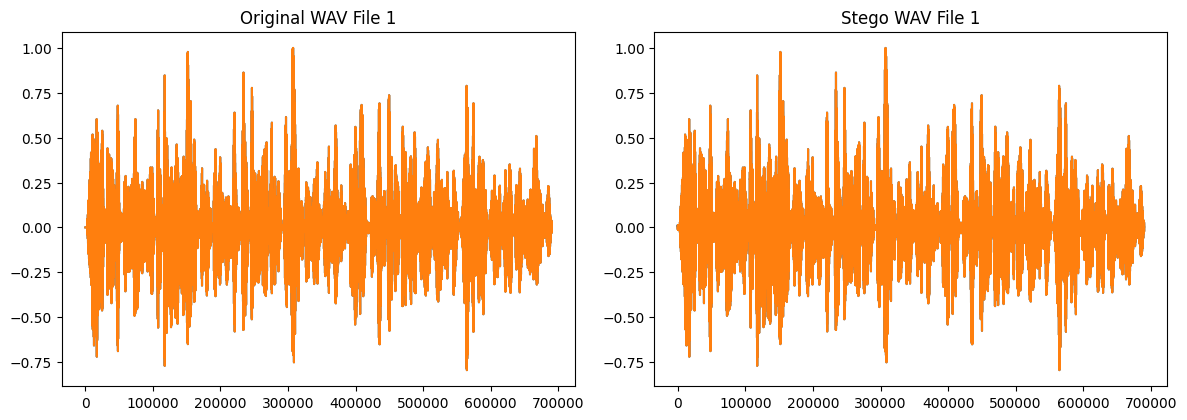

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.io import wavfile
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

input_wav1_path = "/content/sample_data/audio/audio.wav"   # First input audio
stego_wav1_path = "/content/sample_data/audio/stego_audio.wav"

# Load WAV files
sr1, input_audio1 = wavfile.read(input_wav1_path)
sr1_s, stego_audio1 = wavfile.read(stego_wav1_path)

# sr2, input_audio2 = wavfile.read(input_wav2_path)
# sr2_s, stego_audio2 = wavfile.read(stego_wav2_path)

# Normalize audio
input_audio1 = input_audio1 / np.max(np.abs(input_audio1))
stego_audio1 = stego_audio1 / np.max(np.abs(stego_audio1))

# input_audio2 = input_audio2 / np.max(np.abs(input_audio2))
# stego_audio2 = stego_audio2 / np.max(np.abs(stego_audio2))

# Plot waveforms
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(input_audio1)
plt.title("Original WAV File 1")

plt.subplot(2, 2, 2)
plt.plot(stego_audio1)
plt.title("Stego WAV File 1")

# plt.subplot(2, 2, 3)
# plt.plot(input_audio2)
# plt.title("Original WAV File 2")

# plt.subplot(2, 2, 4)
# plt.plot(stego_audio2)
# plt.title("Stego WAV File 2")

plt.tight_layout()
plt.show()

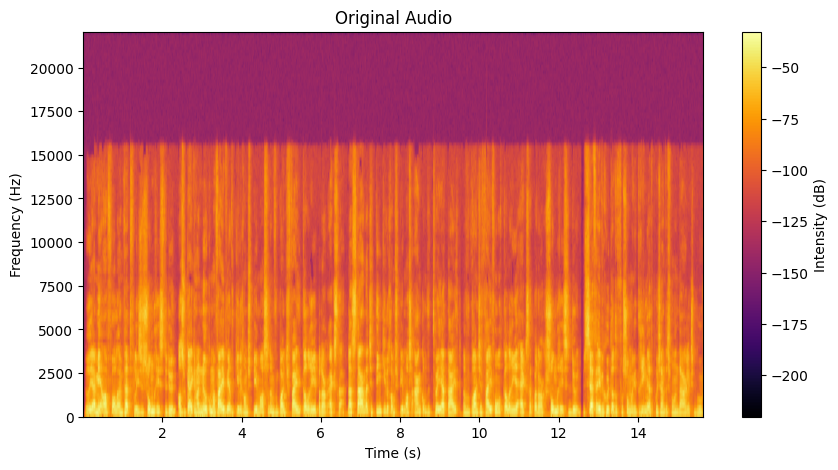

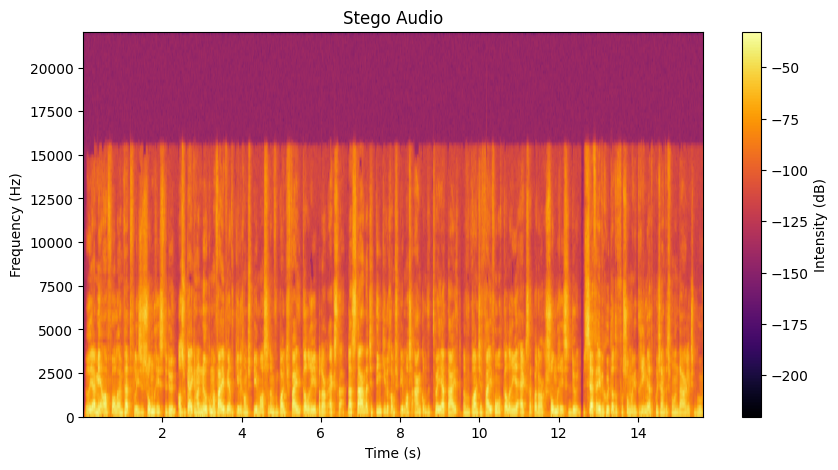

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

def plot_spectrogram(filename, title):
    rate, data = wav.read(filename)

    # Convert stereo to mono if needed
    if len(data.shape) > 1:  # If stereo (2D array)
        data = np.mean(data, axis=1)  # Take the mean of the two channels

    # Normalize data to range [-1, 1] for better visualization
    data = data.astype(np.float32) / np.max(np.abs(data))

    # Plot spectrogram
    plt.figure(figsize=(10, 5))
    plt.specgram(data, Fs=rate, cmap="inferno")
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.colorbar(label="Intensity (dB)")
    plt.show()

plot_spectrogram("/content/sample_data/audio/audio.wav", "Original Audio")
plot_spectrogram("/content/sample_data/audio/stego_audio.wav", "Stego Audio")


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


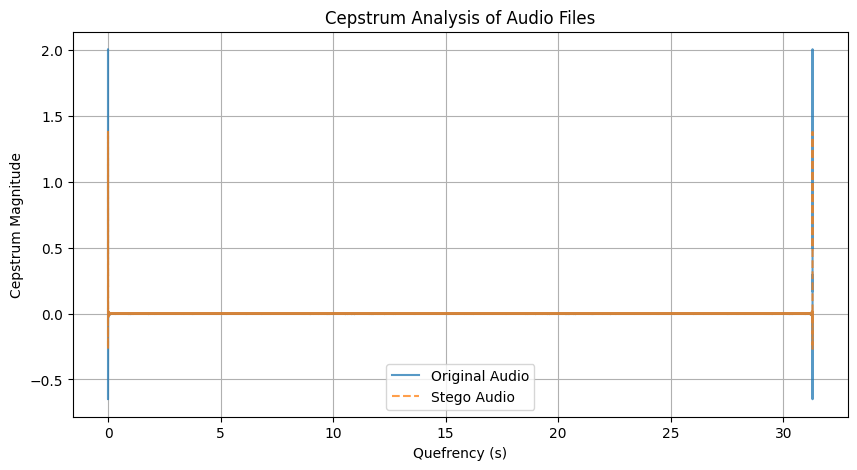

In [ ]:
import numpy as np
import wave
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft

def read_audio(file_path):
    """ Read an audio file and return the normalized waveform and sample rate """
    with wave.open(file_path, 'rb') as wav_file:
        sample_rate = wav_file.getframerate()
        num_frames = wav_file.getnframes()
        audio_data = np.frombuffer(wav_file.readframes(num_frames), dtype=np.int16)

        # Normalize the signal to [-1, 1] to avoid scaling issues
        audio_data = audio_data / np.max(np.abs(audio_data))

    return audio_data, sample_rate

def compute_cepstrum(audio_data):
    """ Compute the real cepstrum of an audio signal """
    spectrum = fft(audio_data)
    log_spectrum = np.log(np.abs(spectrum) + 1e-10)  # Avoid log(0) issues
    cepstrum = np.real(ifft(log_spectrum))
    return cepstrum

def plot_cepstrum(cepstrum1, cepstrum2, sample_rate):
    """ Plot the cepstral analysis for both audio files """
    quefrency = np.arange(len(cepstrum1)) / sample_rate  # Convert to seconds

    plt.figure(figsize=(10, 5))
    plt.plot(quefrency, cepstrum1, label="Original Audio", alpha=0.75)
    plt.plot(quefrency, cepstrum2, label="Stego Audio", alpha=0.75, linestyle="dashed")
    plt.xlabel("Quefrency (s)")
    plt.ylabel("Cepstrum Magnitude")
    plt.title("Cepstrum Analysis of Audio Files")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    # Provide file paths
    original_audio_path = "/content/sample_data/audio/audio.wav"
    stego_audio_path = "/content/sample_data/audio/stego_audio.wav"

    # Read audio data
    original_audio, sample_rate = read_audio(original_audio_path)
    stego_audio, _ = read_audio(stego_audio_path)  # Sample rate is same

    # Compute cepstrum
    cepstrum_original = compute_cepstrum(original_audio)
    cepstrum_stego = compute_cepstrum(stego_audio)

    # Plot the cepstral differences
    plot_cepstrum(cepstrum_original, cepstrum_stego, sample_rate)

<ipython-input-76-1b2ade97000f>:60: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


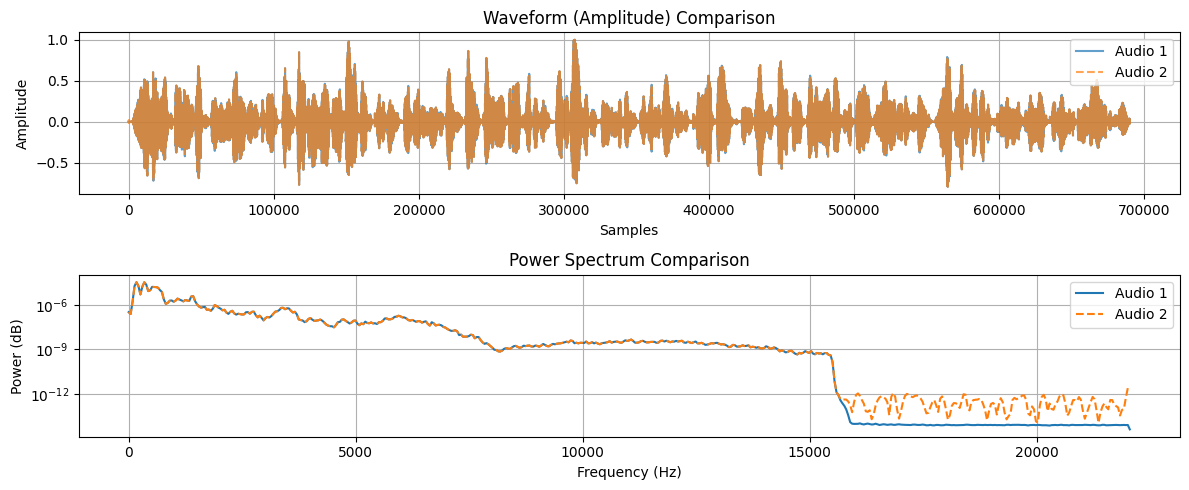

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import scipy.signal as signal

def load_audio(file_path):
    """ Load a WAV file and normalize the audio signal """
    sample_rate, data = wav.read(file_path)

    # Convert to mono if stereo
    if len(data.shape) > 1:
        data = np.mean(data, axis=1)

    # Normalize
    data = data / np.max(np.abs(data))

    return sample_rate, data

def compute_power_spectrum(audio_signal, sample_rate):
    """ Compute the power spectrum of the audio signal """
    freqs, psd = signal.welch(audio_signal, fs=sample_rate, nperseg=1024)
    return freqs, psd

# Load two different audio files
file1 = "/content/sample_data/audio/audio.wav"
file2 = "/content/sample_data/audio/stego_audio.wav"

sr1, audio1 = load_audio(file1)
sr2, audio2 = load_audio(file2)

# Ensure both files have the same length for comparison
min_len = min(len(audio1), len(audio2))
audio1, audio2 = audio1[:min_len], audio2[:min_len]

# Compute power spectrum
freqs1, psd1 = compute_power_spectrum(audio1, sr1)
freqs2, psd2 = compute_power_spectrum(audio2, sr2)

# Plot Amplitude (Waveform)
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(audio1, label="Audio 1", alpha=0.7)
plt.plot(audio2, label="Audio 2", alpha=0.7, linestyle="dashed")
plt.title("Waveform (Amplitude) Comparison")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()

# Plot Power Spectrum
plt.subplot(2, 1, 2)
plt.semilogy(freqs1, psd1, label="Audio 1")
plt.semilogy(freqs2, psd2, label="Audio 2", linestyle="dashed")
plt.title("Power Spectrum Comparison")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import scipy.io.wavfile as wav
from skimage.metrics import structural_similarity as ssim

# Load the WAV files
sr1, data1 = wav.read("/content/sample_data/audio/audio.wav")
sr2, data2 = wav.read("/content/sample_data/audio/stego_audio.wav")

# Convert to mono if stereo
if len(data1.shape) > 1:
    data1 = np.mean(data1, axis=1)
if len(data2.shape) > 1:
    data2 = np.mean(data2, axis=1)

# Normalize to [-1, 1] (avoid overflow issues)
data1 = data1.astype(np.float32) / np.max(np.abs(data1))
data2 = data2.astype(np.float32) / np.max(np.abs(data2))

# Resize to the same length for comparison
min_len = min(len(data1), len(data2))
data1, data2 = data1[:min_len], data2[:min_len]

# Compute SSIM with a proper dynamic range
similarity = ssim(data1, data2, data_range=data1.max() - data1.min())

print(f"SSIM: {similarity}")


SSIM: 0.999917828422996


In [ ]:
import numpy as np
import wave

def read_audio(file_path):
    """ Read audio file and return normalized waveform data. """
    with wave.open(file_path, 'rb') as wav_file:
        params = wav_file.getparams()
        num_frames = wav_file.getnframes()
        audio_data = np.frombuffer(wav_file.readframes(num_frames), dtype=np.int16)

        # Normalize the data to [-1, 1] if needed
        audio_data = audio_data / np.max(np.abs(audio_data))

    return audio_data

def calculate_mse_psnr(original_audio, stego_audio):
    """ Calculate MSE and PSNR between original and modified audio """
    # Ensure both audio arrays have the same length
    min_length = min(len(original_audio), len(stego_audio))
    original_audio = original_audio[:min_length]
    stego_audio = stego_audio[:min_length]

    # Compute MSE
    mse = np.mean((original_audio - stego_audio) ** 2)

    # Compute PSNR (Peak Signal-to-Noise Ratio)
    if mse == 0:
        psnr = float('inf')  # No noise, infinite PSNR
    else:
        max_val = np.max(np.abs(original_audio))  # Peak signal value
        psnr = 10 * np.log10((max_val ** 2) / mse)

    return mse, psnr

if __name__ == "__main__":
    original_audio_path = "/content/sample_data/audio/audio.wav"  # Update with actual file path
    stego_audio_path = "/content/sample_data/audio/stego_audio.wav"        # Update with actual file path

    # Read audio files
    original_audio = read_audio(original_audio_path)
    stego_audio = read_audio(stego_audio_path)

    # Compute MSE and PSNR
    mse, psnr = calculate_mse_psnr(original_audio, stego_audio)

    # Display results
    print(f"MSE: {mse:.15f}")
    print(f"PSNR: {psnr:.2f} dB")


MSE: 0.000000061435176
PSNR: 72.12 dB


In [ ]:
import wave
import base64
import hashlib
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP, AES
from Crypto.Util.Padding import unpad

# === Paths ===
WORKING_DIR = "/content/sample_data/"
INPUT_STEGO_AUDIO = WORKING_DIR + "audio/stego_audio.wav"  # LSB-based audio
RSA_PRIVATE_KEY_PATH = WORKING_DIR + "keys/private_key.pem"
OUTPUT_DECRYPTED_TEXT = WORKING_DIR + "decrypted_output_lsb.txt"

# === Step 1: Extract binary from LSBs ===
def lsb_extract(audio_path, data_length_bits):
    with wave.open(audio_path, 'rb') as audio:
        frames = bytearray(audio.readframes(audio.getnframes()))
    binary_data = ''
    for i in range(data_length_bits):
        binary_data += str(frames[i] & 1)
    return binary_data

# === Step 2: Binary to string ===
def binary_to_string(binary_data):
    chars = [binary_data[i:i+8] for i in range(0, len(binary_data), 8)]
    return ''.join([chr(int(b, 2)) for b in chars])

# === Step 3: RSA decryption of AES key ===
def rsa_decrypt(encrypted_key_b64, private_key_path):
    encrypted_key = base64.b64decode(encrypted_key_b64)
    with open(private_key_path, "rb") as key_file:
        private_key = RSA.import_key(key_file.read())
    cipher_rsa = PKCS1_OAEP.new(private_key)
    decrypted_key = cipher_rsa.decrypt(encrypted_key)
    return decrypted_key

# === Step 4: AES decryption ===
def aes_decrypt(encrypted_message_b64, aes_key):
    encrypted_message = base64.b64decode(encrypted_message_b64)
    iv = encrypted_message[:16]
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    decrypted = unpad(cipher.decrypt(encrypted_message[16:]), AES.block_size)
    return decrypted.decode('utf-8')

# === Step 5: Hybrid Hash Validation ===
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# === MAIN ===
if __name__ == "__main__":
    # Set expected size in characters (as per embedding step)
    expected_data_length_chars = 304  # Adjust this if your combined message length changes
    data_length_bits = expected_data_length_chars * 8

    # Step 1: Extract binary and convert to string
    extracted_bin = lsb_extract(INPUT_STEGO_AUDIO, data_length_bits)
    extracted_str = binary_to_string(extracted_bin)

    try:
        encrypted_message, encrypted_key_b64, extracted_hash = extracted_str.split("||")
    except ValueError:
        raise ValueError("❌ Could not split embedded data. Format mismatch or incomplete data.")

    # Step 2: Decrypt AES key using RSA private key
    aes_key = rsa_decrypt(encrypted_key_b64, RSA_PRIVATE_KEY_PATH)

    # Step 3: Decrypt message using AES
    decrypted_message = aes_decrypt(encrypted_message, aes_key)

    # Step 4: Verify hash
    computed_hash = hybrid_hash(decrypted_message)
    if computed_hash == extracted_hash:
        print("[✅] Hash Verified! Message Integrity Intact.")
    else:
        print("[⚠️] Hash Mismatch! Message May Be Corrupted.")

    # Step 5: Save output
    with open(OUTPUT_DECRYPTED_TEXT, "w") as out_file:
        out_file.write(decrypted_message)

    print(f"[📄] Decrypted message saved to: {OUTPUT_DECRYPTED_TEXT}")


[✅] Hash Verified! Message Integrity Intact.
[📄] Decrypted message saved to: /content/sample_data/decrypted_output_lsb.txt


In [ ]:
import wave
import base64
import hashlib
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP, AES
from Crypto.Util.Padding import unpad

# === Paths ===
WORKING_DIR = "/content/sample_data/"
INPUT_STEGO_AUDIO = WORKING_DIR + "audio/extracted_stego_audio.wav"  # LSB-based audio
RSA_PRIVATE_KEY_PATH = WORKING_DIR + "keys/private_key.pem"
OUTPUT_DECRYPTED_TEXT = WORKING_DIR + "decrypted_output_lsb.txt"

# === Step 1: Extract binary from LSBs ===
def lsb_extract(audio_path, data_length_bits):
    with wave.open(audio_path, 'rb') as audio:
        frames = bytearray(audio.readframes(audio.getnframes()))
    binary_data = ''
    for i in range(data_length_bits):
        binary_data += str(frames[i] & 1)
    return binary_data

# === Step 2: Binary to string ===
def binary_to_string(binary_data):
    chars = [binary_data[i:i+8] for i in range(0, len(binary_data), 8)]
    return ''.join([chr(int(b, 2)) for b in chars])

# === Step 3: RSA decryption of AES key ===
def rsa_decrypt(encrypted_key_b64, private_key_path):
    encrypted_key = base64.b64decode(encrypted_key_b64)
    with open(private_key_path, "rb") as key_file:
        private_key = RSA.import_key(key_file.read())
    cipher_rsa = PKCS1_OAEP.new(private_key)
    decrypted_key = cipher_rsa.decrypt(encrypted_key)
    return decrypted_key

# === Step 4: AES decryption ===
def aes_decrypt(encrypted_message_b64, aes_key):
    encrypted_message = base64.b64decode(encrypted_message_b64)
    iv = encrypted_message[:16]
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    decrypted = unpad(cipher.decrypt(encrypted_message[16:]), AES.block_size)
    return decrypted.decode('utf-8')

# === Step 5: Hybrid Hash Validation ===
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# === MAIN ===
if __name__ == "__main__":
    # Set expected size in characters (as per embedding step)
    expected_data_length_chars = 304  # Adjust this if your combined message length changes
    data_length_bits = expected_data_length_chars * 8

    # Step 1: Extract binary and convert to string
    extracted_bin = lsb_extract(INPUT_STEGO_AUDIO, data_length_bits)
    extracted_str = binary_to_string(extracted_bin)

    try:
        encrypted_message, encrypted_key_b64, extracted_hash = extracted_str.split("||")
    except ValueError:
        raise ValueError("❌ Could not split embedded data. Format mismatch or incomplete data.")

    # Step 2: Decrypt AES key using RSA private key
    aes_key = rsa_decrypt(encrypted_key_b64, RSA_PRIVATE_KEY_PATH)

    # Step 3: Decrypt message using AES
    decrypted_message = aes_decrypt(encrypted_message, aes_key)

    # Step 4: Verify hash
    computed_hash = hybrid_hash(decrypted_message)
    if computed_hash == extracted_hash:
        print("[✅] Hash Verified! Message Integrity Intact.")
    else:
        print("[⚠️] Hash Mismatch! Message May Be Corrupted.")

    # Step 5: Save output
    with open(OUTPUT_DECRYPTED_TEXT, "w") as out_file:
        out_file.write(decrypted_message)

    print(f"[📄] Decrypted message saved to: {OUTPUT_DECRYPTED_TEXT}")


ValueError: ❌ Could not split embedded data. Format mismatch or incomplete data.

In [ ]:
import cv2
import os

# === Replace with your paths ===
input_video_path = "/content/sample_data/muted_video.mp4"
metadata_path = "/content/sample_data/InfoOfSecretText/metadata.txt"
stego_frames_folder = "/content/sample_data/stego_frames"
output_video_path = "/content/sample_data/output/modified_video.avi"  # Use .avi for lossless

# Step 1: Read frame indexes from metadata
try:
    with open(metadata_path, 'r') as f:
        content = f.read()
        frame_indexes = sorted(set(
            int(idx.strip()) for idx in content.split(',') if idx.strip().isdigit()
        ))
except FileNotFoundError:
    raise FileNotFoundError(f"🚫 Metadata file not found: {metadata_path}")
except ValueError as e:
    raise ValueError(f"🚫 Metadata contains invalid entries: {e}")

frame_indexes_set = set(frame_indexes)
print(f"[ℹ️] Frame indexes to replace: {frame_indexes}")

# Step 2: Open input video
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    raise IOError(f"❌ Could not open video: {input_video_path}")

fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Step 3: Create output folder and video writer
os.makedirs(os.path.dirname(output_video_path), exist_ok=True)
fourcc = cv2.VideoWriter_fourcc(*'FFV1')  # Lossless
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Step 4: Read video and replace frames
frame_id = 0
replaced = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_id in frame_indexes_set:
        stego_path = os.path.join(stego_frames_folder, f"stego_frame_{frame_id}.png")
        if os.path.exists(stego_path):
            stego_img = cv2.imread(stego_path)
            if stego_img is not None:
                stego_img = cv2.resize(stego_img, (width, height))
                out.write(stego_img)
                replaced += 1
                print(f"[🔁] Replaced frame {frame_id} with stego_frame_{frame_id}.png")
                frame_id += 1
                continue  # Skip writing original frame

        print(f"⚠️ Stego frame not found or invalid at: {stego_path}, writing original frame instead")

    # Write original frame if not replacing
    out.write(frame)
    frame_id += 1

cap.release()
out.release()
print(f"\n✅ Finished! Replaced {replaced}/{len(frame_indexes)} frames.")
print(f"📽️ Modified video saved at: {output_video_path}")


[ℹ️] Frame indexes to replace: [0, 5, 10, 15, 50]
[🔁] Replaced frame 0 with stego_frame_0.png
[🔁] Replaced frame 5 with stego_frame_5.png
[🔁] Replaced frame 10 with stego_frame_10.png
[🔁] Replaced frame 15 with stego_frame_15.png
[🔁] Replaced frame 50 with stego_frame_50.png

✅ Finished! Replaced 5/5 frames.
📽️ Modified video saved at: /content/sample_data/output/modified_video.avi


In [ ]:
import cv2
import os

# === Config ===
input_video = "/content/sample_data/muted_stego_video.avi"
metadata_path = "/content/sample_data/InfoOfSecretText/metadata.txt"   # e.g., "10,25,33"
output_folder = "/content/sample_data/output_extracted_frames1/"

# === Read metadata ===
with open(metadata_path, 'r') as f:
    frame_indexes = [int(i.strip()) for i in f.read().split(",") if i.strip().isdigit()]
frame_indexes_set = set(frame_indexes)

# === Prepare output folder
os.makedirs(output_folder, exist_ok=True)

# === Open modified video
cap = cv2.VideoCapture(input_video)
frame_id = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_id in frame_indexes_set:
        output_path = os.path.join(output_folder, f"stego_frame_{frame_id}.png")
        cv2.imwrite(output_path, frame)
        print(f"[💾] Extracted frame {frame_id} → stego_frame_{frame_id}.png")

    frame_id += 1

cap.release()
print(f"\n✅ Frames extracted to: {output_folder}")


[💾] Extracted frame 0 → stego_frame_0.png
[💾] Extracted frame 5 → stego_frame_5.png
[💾] Extracted frame 10 → stego_frame_10.png
[💾] Extracted frame 15 → stego_frame_15.png
[💾] Extracted frame 50 → stego_frame_50.png

✅ Frames extracted to: /content/sample_data/output_extracted_frames1/


In [ ]:
import subprocess

def merge_audio_ffmpeg(video_path, audio_path, output_path):
    try:
        command = [
            "ffmpeg", "-i", video_path, "-i", audio_path,
            "-c:v", "copy", "-c:a", "aac", "-b:a", "192k",  # Convert audio to AAC
            "-map", "0:v:0", "-map", "1:a:0",
            "-y", output_path
        ]
        subprocess.run(command, check=True)
        print(f"✅ Video merged successfully without compression: {output_path}")
    except subprocess.CalledProcessError as e:
        print(f"❌ FFmpeg Error: {e}")

merge_audio_ffmpeg(
    "/content/sample_data/output/modified_video.avi",
    "/content/sample_data/audio/stego_audio.wav",
    "/content/sample_data/stego_video.avi"
)


✅ Video merged successfully without compression: /content/sample_data/stego_video.avi


In [ ]:
import os

# Paths
video_file_path = '/content/sample_data/stego_video.avi'  # Replace with your video file path
audio_file_path = '/content/sample_data/audio/extracted_stego_audio.wav'  # Save extracted audio as WAV
muted_video_path = '/content/sample_data/muted_stego_video.avi'  # Save muted video

# Extract audio from video
os.system(f'ffmpeg -i "{video_file_path}" -q:a 0 -map a "{audio_file_path}"')
print(f"Audio extracted and saved at: {audio_file_path}")

# Create muted video (video without audio)
os.system(f'ffmpeg -i "{video_file_path}" -c copy -an "{muted_video_path}"')
print(f"Muted video saved at: {muted_video_path}")


Audio extracted and saved at: /content/sample_data/audio/extracted_stego_audio.wav
Muted video saved at: /content/sample_data/muted_stego_video.avi


----------------------------------------------------------------------------------------------------------------------------------------------------------------------
not necessary

same code avoid it

In [ ]:
import os
import base64
import hashlib
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad

# === Paths ===
WORKING_DIR = "/content/sample_data/"
EXTRACTED_FOLDER = os.path.join(WORKING_DIR, "extracted_text_parts/")
OUTPUT_FOLDER = os.path.join(WORKING_DIR, "decrypted_output/")
AES_KEY_PATH = os.path.join(WORKING_DIR, "keys/aes_key.bin")
COMBINED_ENCRYPTED_TEXT_PATH = os.path.join(OUTPUT_FOLDER, "combined_encrypted_text.txt")  # Base64 format

# === Ensure output folder exists ===
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# === Step 1: Combine extracted text parts (1-4) ===
try:
    combined_data = ""
    for i in range(1, 5):  # Parts 1 to 4
        part_path = os.path.join(EXTRACTED_FOLDER, f"extracted_part_{i}.txt")
        with open(part_path, "r", encoding="utf-8") as f:
            combined_data += f.read().strip()

    # Save the combined encrypted text (Base64 format)
    with open(COMBINED_ENCRYPTED_TEXT_PATH, "w", encoding="utf-8") as f:
        f.write(combined_data)

    print("[📜] Extracted parts combined successfully.")

except Exception as e:
    print("❌ Error combining extracted parts:", e)
    exit()

# === Step 2: Load AES key ===
with open(AES_KEY_PATH, "rb") as key_file:
    aes_key = key_file.read().strip()

if len(aes_key) not in [16, 24, 32]:
    print("❌ Invalid AES key length:", len(aes_key))
    exit()
else:
    print("[🔑] AES key loaded. Length:", len(aes_key))

# === Step 3: Read and decode the Base64 encrypted data ===
try:
    with open(COMBINED_ENCRYPTED_TEXT_PATH, "r") as f:
        base64_data = f.read().strip()

    encrypted_data = base64.b64decode(base64_data)
    iv = encrypted_data[:16]
    ciphertext = encrypted_data[16:]

    if len(ciphertext) % AES.block_size != 0:
        raise ValueError(f"❌ Ciphertext is not a multiple of 16 bytes. Found: {len(ciphertext)}")

    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    decrypted_padded = cipher.decrypt(ciphertext)
    decrypted_text = unpad(decrypted_padded, AES.block_size).decode()

    print("[🔓] Decryption successful.")

except Exception as e:
    print("❌ Decryption failed:", e)
    exit()

# === Step 4: Save decrypted result ===
decrypted_path = os.path.join(OUTPUT_FOLDER, "decoded_secret_text.txt")
with open(decrypted_path, "w", encoding="utf-8") as out_file:
    out_file.write(decrypted_text)

print(f"[💾] Decrypted text saved at: {decrypted_path}")

# === Step 5: Hybrid Hashing (MD5 ➝ SHA256) ===
def hybrid_hash(data):
    md5_hash = hashlib.md5(data.encode()).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode()).hexdigest()
    return sha256_hash

generated_hash = hybrid_hash(decrypted_text)

# === Step 6: Load extracted hash (from stego frame) ===
hash_path = os.path.join(EXTRACTED_FOLDER, "extracted_part_5.txt")
with open(hash_path, "r", encoding="utf-8") as f:
    extracted_hash = f.read().strip()

# === Step 7: Compare hashes ===
print("\n🔁 Comparing generated hash with extracted hash:")
print("Generated Hybrid Hash (MD5 ➝ SHA256):", generated_hash)
print("Extracted Hash from Frame:            ", extracted_hash)

if generated_hash == extracted_hash:
    print("\n✅ SUCCESS: Decryption verified. Data integrity intact!")
else:
    print("\n❌ CORRUPTED: Hash mismatch detected.")


[📜] Extracted parts combined successfully.
[🔑] AES key loaded. Length: 32
[🔓] Decryption successful.
[💾] Decrypted text saved at: /content/sample_data/decrypted_output/decoded_secret_text.txt

🔁 Comparing generated hash with extracted hash:
Generated Hybrid Hash (MD5 ➝ SHA256): 5a749373887c0d5d6a2ed44e03b7fb2804c7d39fea31d583909f9aa386516c84
Extracted Hash from Frame:             5a749373887c0d5d6a2ed44e03b7fb2804c7d39fea31d583909f9aa386516c84

✅ SUCCESS: Decryption verified. Data integrity intact!


In [ ]:
import subprocess

def convert_to_pcm(input_path, output_path):
    cmd = [
        "ffmpeg", "-y",
        "-i", input_path,
        "-acodec", "pcm_s16le",
        "-ar", "44100",
        "-ac", "1",
        output_path
    ]
    subprocess.run(cmd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print(f"[🔁] Audio converted to PCM format: {output_path}")
input_audio_path = "/content/sample_data/audio/audio.wav"
output_audio_path = "/content/sample_data/audio/fixed_audio.wav"
convert_to_pcm(input_audio_path, output_audio_path)

[🔁] Audio converted to PCM format: /content/sample_data/audio/fixed_audio.wav


In [ ]:
import wave

original_path = "/content/sample_data/audio/fixed_audio.wav"

try:
    with wave.open(original_path, "rb") as wav:
        print(f"Channels: {wav.getnchannels()}")
        print(f"Sample Width: {wav.getsampwidth()}")
        print(f"Frame Rate: {wav.getframerate()}")
        print(f"Frames: {wav.getnframes()}")
        print(f"Duration: {wav.getnframes() / wav.getframerate():.2f} seconds")
except wave.Error as e:
    print("❌ wave.Error:", e)
except Exception as ex:
    print("❌ General error:", ex)


Channels: 1
Sample Width: 2
Frame Rate: 44100
Frames: 0
Duration: 0.00 seconds


In [ ]:
import wave
import os
import base64
import hashlib
import numpy as np
from scipy.fftpack import dct, idct
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad

# === Define working directory ===
WORKING_DIR = "/content/sample_data/"

# === Paths ===
AES_KEY_PATH = WORKING_DIR + "keys/aes_key.bin"
ENCRYPTED_AES_KEY_PATH = WORKING_DIR + "keys/encrypted_aes_key.txt"
INPUT_TEXT_PATH = WORKING_DIR + "encrypted_data/info.txt"
INPUT_AUDIO_PATH = WORKING_DIR + "audio/audio.wav"
OUTPUT_AUDIO_LSB = WORKING_DIR + "audio/stego_audio.wav"
OUTPUT_AUDIO_DCT = WORKING_DIR + "audio/stego_audio1.wav"

# === Hybrid Hashing (MD5 ➝ SHA-256) ===
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# === AES Encryption ===
def aes_encrypt(message, aes_key):
    cipher = AES.new(aes_key, AES.MODE_CBC)
    ciphertext = cipher.iv + cipher.encrypt(pad(message.encode('utf-8'), AES.block_size))
    print(ciphertext)
    return base64.b64encode(ciphertext).decode('utf-8')

# === LSB Embedding ===
def lsb_embed(audio_path, binary_data, output_path):
    with wave.open(audio_path, 'rb') as audio:
        params = audio.getparams()
        frames = bytearray(audio.readframes(audio.getnframes()))

    data_len = len(binary_data)
    if data_len > len(frames):
        raise ValueError("❌ Message too large for the given audio file.")

    for i in range(data_len):
        frames[i] = (frames[i] & 0b11111110) | int(binary_data[i])

    with wave.open(output_path, 'wb') as out_audio:
        out_audio.setparams(params)
        out_audio.writeframes(frames)

    print(f"[🎧] LSB stego audio saved to: {output_path}")

# === DCT Embedding ===
def dct_embed(audio_path, binary_data, output_path):
    with wave.open(audio_path, 'rb') as audio:
        params = audio.getparams()
        n_channels = audio.getnchannels()
        sampwidth = audio.getsampwidth()
        framerate = audio.getframerate()
        n_frames = audio.getnframes()
        audio_frames = np.frombuffer(audio.readframes(n_frames), dtype=np.int16)

    samples = audio_frames.copy()
    binary_index = 0
    block_size = 1024

    for i in range(0, len(samples) - block_size, block_size):
        if binary_index >= len(binary_data):
            break

        block = samples[i:i+block_size]
        block_dct = dct(block, norm='ortho')

        bit = int(binary_data[binary_index])
        coeff = block_dct[20]
        coeff = int(coeff) & ~1 | bit
        block_dct[20] = coeff
        binary_index += 1

        idct_block = np.round(idct(block_dct, norm='ortho')).astype(np.int16)
        samples[i:i+block_size] = idct_block

    with wave.open(output_path, 'wb') as out_audio:
        out_audio.setnchannels(n_channels)
        out_audio.setsampwidth(sampwidth)
        out_audio.setframerate(framerate)
        out_audio.writeframes(samples.tobytes())

    print(f"[🎧] DCT stego audio saved to: {output_path}")

# === MAIN ===
if __name__ == "__main__":
    # Load AES key
    with open(AES_KEY_PATH, "rb") as key_file:
        aes_key = key_file.read()

    # Load message
    with open(INPUT_TEXT_PATH, "r") as msg_file:
        message = msg_file.read().strip()

    # Hash
    hash_value = hybrid_hash(message)
    with open(WORKING_DIR + "encrypted_data/hash_value.txt", "w") as hash_file:
        hash_file.write(hash_value)
    print(f"[🔐] Hybrid Hash: {hash_value}")

    # AES encryption
    encrypted_message = aes_encrypt(message, aes_key)

    # Load pre-encrypted AES key (base64 string)
    with open(ENCRYPTED_AES_KEY_PATH, "r") as enc_key_file:
        encrypted_key = enc_key_file.read().strip()

    # Combine message
    combined_data = encrypted_message + "||" + encrypted_key + "||" + hash_value
    binary_data = ''.join(format(ord(char), '08b') for char in combined_data)
    print(binary_data)

    # Save combined and binary
    with open(WORKING_DIR + "encrypted_data/combined_data.txt", "w") as combined_file:
        combined_file.write(combined_data)
    with open(WORKING_DIR + "encrypted_data/binary_message.txt", "w") as bin_file:
        bin_file.write(binary_data)

    # Calculate and print length of combined data in characters and bits
    combined_length_chars = len(combined_data)
    combined_length_bits = len(binary_data)

    print(f"\n[ℹ️] Combined Data Length:")
    print(f"  ➤ Characters: {combined_length_chars}")
    print(f"  ➤ Bits:       {combined_length_bits}")


    # === Embed into audio ===
    lsb_embed(INPUT_AUDIO_PATH, binary_data, OUTPUT_AUDIO_LSB)
    dct_embed(INPUT_AUDIO_PATH, binary_data, OUTPUT_AUDIO_DCT)


[🔐] Hybrid Hash: fb0e8a48d74973838a23c53adc02fb16d07c0a401626fb4e04d0bba2f64181a9
b'\xf1\xcb\xcd\xd5\xd1\x00\x90d\xe1)\xf2\xd6\x92F\x85P\xb0`\x0f+\x95\xfc\x8a\x91\xa0\xae\x1a_\xa2D\xdd\xe2Z\xd5WJ\xd0\xc1\xcb}}\x9b\xf8[w4\xb3\xd4'
00111000011000110111011001001110001100010110010001000101010000010110101101000111010101000110100001001011011001100100110001010111011010110110101101100001010001100101010101001100010000100110011101000100011110010111010101010110001011110100100101110001010100100110111101001011001101000110000101011000001101100100101001000101001100110110010101001010011000010011000101010110011001000100101100110000010011010100100001001100011001100101100000110010011000100010101101000110011101000011001101001110010011000101000001010101011111000111110001100101010101010100001001100001011100010111011001000001011001100111001100101111011101110100011001011001010101010011010001010000011010100101100001101101011100100100111101000011011100000110101101010001010110010011010001001110011101010110100100

In [ ]:
import wave
import base64
import numpy as np
from scipy.fftpack import dct
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP, AES
from Crypto.Util.Padding import unpad
import hashlib

# === Paths ===
WORKING_DIR = "/content/sample_data/"
INPUT_STEGO_AUDIO = WORKING_DIR + "audio/stego_audio1.wav"
RSA_PRIVATE_KEY_PATH = WORKING_DIR + "keys/private_key.pem"
OUTPUT_DECRYPTED_TEXT = WORKING_DIR + "decrypted_output.txt"

# === Step 1: Extract Binary Data from Audio using DCT ===
def dct_extract(audio_path, data_length_bits):
    with wave.open(audio_path, 'rb') as audio:
        samples = np.frombuffer(audio.readframes(audio.getnframes()), dtype=np.int16)

    binary_data = ''
    block_size = 1024
    for i in range(0, len(samples) - block_size, block_size):
        if len(binary_data) >= data_length_bits:
            break
        block = samples[i:i+block_size]
        block_dct = dct(block, norm='ortho')
        bit = int(block_dct[20]) & 1
        binary_data += str(bit)
    print(binary_data)
    return binary_data

# === Step 2: Convert binary to string ===
def binary_to_string(binary_data):
    chars = [binary_data[i:i+8] for i in range(0, len(binary_data), 8)]
    return ''.join([chr(int(b, 2)) for b in chars])

# === Step 3: RSA decryption of AES key ===
def rsa_decrypt(encrypted_key_b64, private_key_path):
    encrypted_key = base64.b64decode(encrypted_key_b64)
    with open(private_key_path, "rb") as key_file:
        private_key = RSA.import_key(key_file.read())
    cipher_rsa = PKCS1_OAEP.new(private_key)
    decrypted_key = cipher_rsa.decrypt(encrypted_key)
    return decrypted_key

# === Step 4: AES decryption ===
def aes_decrypt(encrypted_message_b64, aes_key):
    encrypted_message = base64.b64decode(encrypted_message_b64)
    iv = encrypted_message[:16]
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    decrypted = unpad(cipher.decrypt(encrypted_message[16:]), AES.block_size)
    return decrypted.decode('utf-8')

# === Step 5: Hybrid Hash Validation ===
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# === MAIN ===
if __name__ == "__main__":
    # Step 1: Extract binary and convert to string
    expected_data_length_bytes = 304  # change based on your data length
    extracted_bin = dct_extract(INPUT_STEGO_AUDIO, expected_data_length_bytes * 8)
    extracted_str = binary_to_string(extracted_bin)
    print(extracted_str)
    # Step 2: Split combined data
    try:
        encrypted_message, encrypted_key_b64, extracted_hash = extracted_str.split("||")
    except ValueError:
        raise ValueError("❌ Could not split embedded data. Format mismatch or incomplete data.")

    # Step 3: Decrypt AES key using RSA private key
    aes_key = rsa_decrypt(encrypted_key_b64, RSA_PRIVATE_KEY_PATH)

    # Step 4: Decrypt message using AES
    decrypted_message = aes_decrypt(encrypted_message, aes_key)

    # Step 5: Verify hash
    computed_hash = hybrid_hash(decrypted_message)
    if computed_hash == extracted_hash:
        print("[✅] Hash Verified! Message Integrity Intact.")
    else:
        print("[⚠️] Hash Mismatch! Message May Be Corrupted.")

    # Save output
    with open(OUTPUT_DECRYPTED_TEXT, "w") as out_file:
        out_file.write(decrypted_message)

    print(f"[📄] Decrypted message saved to: {OUTPUT_DECRYPTED_TEXT}")


0100010010010111010111000000010010001011010100010100010001100001110001100001010101100100010100110110101010110110011101001000000101001011011000010011000111101001000101101010101111001001100001001011111001011011001111100111000000001111001001100010010001101101011010101110010000110101100010111111000011001100000110001100000100010110011111001111110110101001111101111010111111010010001010110100111010010000000111010111110101000110111010011101000011110011001111100010110100110111101010101100110100010110110010110111110011011101101100001010011100000010010000011100110110010111000111001011011001000001010011001000101000110001011111101111001000000010111000011111001011110001001110011101000100100010011011100001010100110111110001011010100000011011111000010111001100000010011110011111101101101011100111000011001010001010100000011010011000011000001000011100100100111010011110011100100001000010000000110011011111111100011001010100001010100110100110001010100111111101010111011010101111100111011100001011100011111000

ValueError: ❌ Could not split embedded data. Format mismatch or incomplete data.

In [ ]:
import wave
import os
import random
import base64
import hashlib
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad

# === Define working directory ===
WORKING_DIR = "/content/sample_data/"

# === Paths ===
AES_KEY_PATH = WORKING_DIR + "keys/aes_key.bin"  # actual binary AES key
ENCRYPTED_AES_KEY_PATH = WORKING_DIR + "keys/encrypted_aes_key.txt"  # base64 string of pre-encrypted key
INPUT_TEXT_PATH = WORKING_DIR + "encrypted_data/info.txt"
INPUT_AUDIO_PATH = WORKING_DIR + "audio/audio.wav"
OUTPUT_AUDIO_PATH = WORKING_DIR + "audio/stego_audio.wav"

# === Hybrid Hashing (MD5 → SHA-256) ===
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# === AES Encryption ===
def aes_encrypt(message, aes_key):
    cipher = AES.new(aes_key, AES.MODE_CBC)
    ciphertext = cipher.iv + cipher.encrypt(pad(message.encode('utf-8'), AES.block_size))
    return base64.b64encode(ciphertext).decode('utf-8')

# === Main process ===
if __name__ == "__main__":
    # Load AES key
    with open(AES_KEY_PATH, "rb") as key_file:
        aes_key = key_file.read()

    # Load input text message
    with open(INPUT_TEXT_PATH, "r") as msg_file:
        message = msg_file.read().strip()

    # Compute hybrid hash
    hash_value = hybrid_hash(message)
    with open(WORKING_DIR + "encrypted_data/hash_value.txt", "w") as hash_file:
        hash_file.write(hash_value)
    print(f"Hybrid Hash: {hash_value}")

    # Encrypt message with AES
    encrypted_message = aes_encrypt(message, aes_key)

    # Load pre-encrypted AES key (base64)
    with open(ENCRYPTED_AES_KEY_PATH, "r") as enc_key_file:
        encrypted_key = enc_key_file.read().strip()

    # Combine data
    combined_data = encrypted_message + "||" + encrypted_key + "||" + hash_value

    # Convert to binary
    binary_message = ''.join(format(ord(char), '08b') for char in combined_data)

    # Save combined data and binary message
    with open(WORKING_DIR + "encrypted_data/combined_data.txt", "w") as combined_file:
        combined_file.write(combined_data)

    with open(WORKING_DIR + "encrypted_data/binary_message.txt", "w") as bin_file:
        bin_file.write(binary_message)


Hybrid Hash: 0cd719b9cffee2429df2d7dbb0b4717b0e1422e88a91e581488a5d67adf0bf1a


In [ ]:
import wave

# === Define paths ===
WORKING_DIR = "/content/sample_data/"
INPUT_WAV_PATH = WORKING_DIR + "audio/audio.wav"
TEXT_FILE_PATH = WORKING_DIR + "encrypted_data/info.txt"
OUTPUT_WAV_PATH = WORKING_DIR + "audio/stego_audio.wav"

# === Convert text to binary ===
def text_to_binary(text):
    return ''.join(format(ord(char), '08b') for char in text)

# === LSB embedding ===
def lsb_embed_text(input_wav_path, text_file_path, output_wav_path):
    # Load the text to embed
    with open(text_file_path, 'r') as f:
        message = f.read()

    binary_message = text_to_binary(message)
    message_length = len(binary_message)

    # Open the WAV audio
    with wave.open(input_wav_path, 'rb') as audio:
        params = audio.getparams()
        frames = bytearray(audio.readframes(audio.getnframes()))

    # Check if message fits
    if message_length > len(frames):
        raise ValueError("❌ Message is too large for the selected audio file.")

    # Embed bits into the least significant bit of each audio byte
    for i in range(message_length):
        frames[i] = (frames[i] & 0b11111110) | int(binary_message[i])

    # Save the modified audio
    with wave.open(output_wav_path, 'wb') as out_audio:
        out_audio.setparams(params)
        out_audio.writeframes(frames)

    print(f"[✅] Text successfully embedded in audio using LSB.")
    print(f"[📁] Output file: {output_wav_path}")

# === Run the process ===
if __name__ == "__main__":
    lsb_embed_text(INPUT_WAV_PATH, TEXT_FILE_PATH, OUTPUT_WAV_PATH)


Error: unknown format: 255

In [ ]:
import wave
import os
import random
import base64
import hashlib
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.Util.Padding import pad

# Define working directory
WORKING_DIR = "/content/sample_data/"

# Paths to existing keys
AES_KEY_PATH = WORKING_DIR + "keys/aes_key.bin"
PUBLIC_KEY_PATH = WORKING_DIR + "keys/public_key.pem"
INPUT_TEXT_PATH = WORKING_DIR + "encrypted_data/info.txt"
INPUT_AUDIO_PATH = WORKING_DIR + "audio/audio.wav"
OUTPUT_AUDIO_PATH = WORKING_DIR + "audio/stego_audio.wav"

# Hybrid Hashing (MD5 → SHA-256)
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# AES Encryption using existing key
def aes_encrypt(message, aes_key):
    cipher = AES.new(aes_key, AES.MODE_CBC)
    ciphertext = cipher.iv + cipher.encrypt(pad(message.encode('utf-8'), AES.block_size))
    return base64.b64encode(ciphertext).decode('utf-8')

# RSA Encryption of AES Key using existing public key
def rsa_encrypt_key(aes_key, public_key_path):
    with open(public_key_path, "rb") as key_file:
        public_key = RSA.import_key(key_file.read())
    rsa_cipher = PKCS1_OAEP.new(public_key)
    encrypted_key = rsa_cipher.encrypt(aes_key)
    return base64.b64encode(encrypted_key).decode('utf-8')

# Main process
if __name__ == "__main__":
    # Load AES Key
    with open(AES_KEY_PATH, "rb") as key_file:
        aes_key = key_file.read()

    # Read input message
    with open(INPUT_TEXT_PATH, "r") as msg_file:
        message = msg_file.read().strip()

    # Compute Hybrid Hash
    hash_value = hybrid_hash(message)
    with open(WORKING_DIR + "encrypted_data/hash_value.txt", "w") as hash_file:
        hash_file.write(hash_value)

    print(f"Hybrid Hash: {hash_value}")

    # Encrypt Message with AES
    encrypted_message = aes_encrypt(message, aes_key)

    # Encrypt AES Key using RSA Public Key
    encrypted_key = rsa_encrypt_key(aes_key, PUBLIC_KEY_PATH)

    # Concatenate Data
    combined_data = encrypted_message + "||" + encrypted_key + "||" + hash_value

    # Convert to binary
    binary_message = ''.join(format(ord(char), '08b') for char in combined_data)

    # Save combined data for verification
    with open(WORKING_DIR + "encrypted_data/combined_data.txt", "w") as combined_file:
        combined_file.write(combined_data)

    # Save binary message
    with open(WORKING_DIR + "encrypted_data/binary_message.txt", "w") as bin_file:
        bin_file.write(binary_message)



Hybrid Hash: 2a96953a9ff1573cefc4b95e58cc43fc94fd6503a696af105e962daaff091c8c


In [ ]:
import wave
import os

# === Replace these paths with your own ===
text_file_path = "/content/sample_data/encrypted_data/combined_data.txt"
original_audio_path = "/content/sample_data/audio/audio.wav"
output_audio_path = "/content/sample_data/audio/stego_audio.wav"

def embed_text_in_audio(audio_path, output_path, text_file_path):
    # Step 1: Read the text file
    if not os.path.exists(text_file_path):
        raise FileNotFoundError(f"Text file not found: {text_file_path}")

    with open(text_file_path, "r", encoding="utf-8") as f:
        secret_message = f.read() + '###'  # Add delimiter

    # Step 2: Open audio file and read frames
    try:
        with wave.open(audio_path, mode='rb') as audio:
            frame_bytes = bytearray(list(audio.readframes(audio.getnframes())))
            params = audio.getparams()
    except wave.Error as e:
        raise ValueError(f"Invalid WAV file format: {e}")

    # Step 3: Convert message to binary
    bits = ''.join([format(ord(char), '08b') for char in secret_message])

    # Step 4: Check if the message fits
    if len(bits) > len(frame_bytes):
        raise ValueError("Message too long to embed in the audio file.")

    # Step 5: Embed the bits into the audio data (LSB)
    for i, bit in enumerate(bits):
        frame_bytes[i] = (frame_bytes[i] & 254) | int(bit)

    # Step 6: Write the modified bytes to a new audio file
    with wave.open(output_path, 'wb') as modified_audio:
        modified_audio.setparams(params)
        modified_audio.writeframes(bytes(frame_bytes))

    print(f"[✅] Secret message successfully embedded into: {output_path}")

# Run the embedding process
embed_text_in_audio(original_audio_path, output_audio_path, text_file_path)


ValueError: Invalid WAV file format: unknown format: 255

**for testing decoding of stego_audio **

In [ ]:
import wave
import os
import base64
import random
import hashlib
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.Util.Padding import unpad

# Define working directory
WORKING_DIR = "/content/sample_data/"

# Paths to provided files
PRIVATE_KEY_PATH = WORKING_DIR + "keys/private_key.pem"
STEGO_AUDIO_PATH = WORKING_DIR + "audio/stego_audio.wav"
EXTRACTED_TEXT_PATH = WORKING_DIR + "encrypted_data/extracted_text.txt"

# Hybrid Hashing (MD5 → SHA-256) for verification
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# Extract binary data from LSB without AES key
def extract_data(audio_path, length=476):
    with wave.open(audio_path, 'rb') as audio:
        frames = bytearray(audio.readframes(audio.getnframes()))

    # Extract LSBs in sequential order (NO RANDOMIZATION since we don't have AES key yet)
    binary_message = ''.join(str((frames[i] & 1)) for i in range(length * 8))

    # Convert binary to text
    extracted_text = ''.join(chr(int(binary_message[i:i+8], 2)) for i in range(0, len(binary_message), 8))

    # Save extracted data for debugging
    with open(EXTRACTED_TEXT_PATH, "w") as extracted_file:
        extracted_file.write(extracted_text)

    return extracted_text

# RSA Decryption of AES Key
def rsa_decrypt_key(encrypted_key, private_key_path):
    with open(private_key_path, "rb") as key_file:
        private_key = RSA.import_key(key_file.read())
    rsa_cipher = PKCS1_OAEP.new(private_key)
    decrypted_key = rsa_cipher.decrypt(base64.b64decode(encrypted_key))
    return decrypted_key

# AES Decryption of Message
def aes_decrypt(ciphertext, aes_key):
    raw_data = base64.b64decode(ciphertext)
    iv = raw_data[:16]  # Extract IV
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    decrypted_text = unpad(cipher.decrypt(raw_data[16:]), AES.block_size)
    return decrypted_text.decode('utf-8')

# Main decryption process
if __name__ == "__main__":
    # Extract data from stego audio
    extracted_text = extract_data(STEGO_AUDIO_PATH)

    # Split extracted data
    try:
        encrypted_message, encrypted_aes_key, received_hash = extracted_text.split("||")

        # Decrypt AES key using RSA
        decrypted_aes_key = rsa_decrypt_key(encrypted_aes_key, PRIVATE_KEY_PATH)

        # Decrypt message using AES key
        decrypted_message = aes_decrypt(encrypted_message, decrypted_aes_key)

        # Verify hash integrity
        computed_hash = hybrid_hash(decrypted_message)

        if computed_hash == received_hash:
            print("✅ Hash verification successful! Message is intact.")
        else:
            print("⚠️ Hash mismatch! Data may be tampered.")

        print("\n🔓 Decrypted Message:\n", decrypted_message)

    except ValueError:
        print("❌ Extraction error: Data may be corrupted or incomplete.")


❌ Extraction error: Data may be corrupted or incomplete.


In [ ]:
import cv2
import os

def replace_frames(video_path, stego_frames_folder, metadata_file, output_path):
    # Read metadata file for frame indices
    with open(metadata_file, 'r') as f:
        metadata_content = f.read().strip()

    if not metadata_content:
        print("❌ Error: Metadata file is empty.")
        return

    try:
        frame_indices = list(map(int, metadata_content.split(',')))
    except ValueError:
        print("❌ Error: Metadata file contains invalid data.")
        return

    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: Unable to open video '{video_path}'.")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    print(f"🎥 Video Loaded: {total_frames} frames, {fps} FPS, {frame_width}x{frame_height} resolution.")

    # Define video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Replace frame if it's in metadata
        if frame_count in frame_indices:
            stego_frame_path = os.path.join(stego_frames_folder, f'stego_frame_{frame_count}.png')

            if os.path.exists(stego_frame_path):
                stego_frame = cv2.imread(stego_frame_path)

                if stego_frame is None:
                    print(f"⚠️ Warning: Could not read stego frame {stego_frame_path}. Skipping.")
                else:
                    stego_frame = cv2.resize(stego_frame, (frame_width, frame_height))
                    frame = stego_frame
            else:
                print(f"⚠️ Warning: Stego frame {stego_frame_path} not found. Using original frame.")

        out.write(frame)
        frame_count += 1

    # Release resources
    cap.release()
    out.release()

    print(f"✅ Modified video saved at: {output_path}")

# Example usage with corrected paths
replace_frames(
    video_path="/content/sample_data/muted_video.mp4",
    stego_frames_folder="/content/sample_data/stego_frames",  # Corrected folder path
    metadata_file="/content/sample_data/InfoOfSecretText/metadata.txt",  # Check metadata format
    output_path="/content/sample_data/modified_video.mp4"
)


🎥 Video Loaded: 471 frames, 30 FPS, 576x1024 resolution.
✅ Modified video saved at: /content/sample_data/modified_video.mp4


In [ ]:
import cv2
import os

def extract_stego_frames(video_path, metadata_file, output_folder):
    # Create output directory if not exists
    os.makedirs(output_folder, exist_ok=True)

    # Read metadata (indices of stego frames)
    with open(metadata_file, 'r') as f:
        metadata_content = f.read().strip()

    if not metadata_content:
        print("❌ Error: Metadata file is empty.")
        return

    try:
        frame_indices = list(map(int, metadata_content.split(',')))
    except ValueError:
        print("❌ Error: Metadata file contains invalid data.")
        return

    frame_indices_set = set(frame_indices)  # for quick lookup

    # Open video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ Error: Unable to open video '{video_path}'.")
        return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"🎥 Extracting stego frames from video with {total_frames} frames...")

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count in frame_indices_set:
            output_frame_path = os.path.join(output_folder, f"stego_frame_{frame_count}.png")
            cv2.imwrite(output_frame_path, frame)
            print(f"[🖼️] Saved stego frame {frame_count} → {output_frame_path}")

        frame_count += 1

    cap.release()
    print(f"✅ All specified stego frames extracted to: {output_folder}")

# === Example Usage ===
extract_stego_frames(
    video_path="/content/sample_data/modified_video.mp4",
    metadata_file="/content/sample_data/InfoOfSecretText/metadata.txt",
    output_folder="/content/sample_data/extracted_stego_frames"
)


🎥 Extracting stego frames from video with 471 frames...
[🖼️] Saved stego frame 0 → /content/sample_data/extracted_stego_frames/stego_frame_0.png
[🖼️] Saved stego frame 5 → /content/sample_data/extracted_stego_frames/stego_frame_5.png
[🖼️] Saved stego frame 10 → /content/sample_data/extracted_stego_frames/stego_frame_10.png
[🖼️] Saved stego frame 15 → /content/sample_data/extracted_stego_frames/stego_frame_15.png
[🖼️] Saved stego frame 50 → /content/sample_data/extracted_stego_frames/stego_frame_50.png
✅ All specified stego frames extracted to: /content/sample_data/extracted_stego_frames


In [ ]:
import cv2
import os

# === Replace these paths ===
video_path = "/content/sample_data/modified_video.avi"
metadata_path = "/content/sample_data/InfoOfSecretText/metadata.txt"
output_folder = "/content/sample_data/decoded_stego_frames"

# Step 1: Read comma-separated frame indexes from metadata file
try:
    with open(metadata_path, 'r') as f:
        content = f.read()
        frame_indexes = sorted(set(
            int(idx.strip()) for idx in content.split(',') if idx.strip().isdigit()
        ))
except FileNotFoundError:
    raise FileNotFoundError(f"🚫 Metadata file not found: {metadata_path}")
except ValueError as e:
    raise ValueError(f"🚫 Metadata contains invalid entries: {e}")

# Handle empty metadata
if not frame_indexes:
    raise ValueError("🚫 No valid frame indexes found in metadata file.")

print(f"[ℹ️] Frame indexes to extract: {frame_indexes}")

# Step 2: Create output folder
os.makedirs(output_folder, exist_ok=True)

# Step 3: Open the video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError(f"❌ Could not open video: {video_path}")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"[ℹ️] Total frames in video: {total_frames}")

# Step 4: Extract frames using direct seeking (accurate)
saved = 0
for index in frame_indexes:
    if index >= total_frames:
        print(f"⚠️ Skipping index {index} — exceeds total frame count.")
        continue

    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    ret, frame = cap.read()
    if not ret:
        print(f"❌ Failed to read frame at index {index}")
        continue

    output_path = os.path.join(output_folder, f"frame_{index}.jpg")
    cv2.imwrite(output_path, frame)
    print(f"[✅] Saved: frame_{index}.jpg")
    saved += 1

cap.release()
print(f"\n🎉 Done! {saved}/{len(frame_indexes)} frames saved in: {output_folder}")


[ℹ️] Frame indexes to extract: [405, 410, 455, 460, 465]
[ℹ️] Total frames in video: 480
[✅] Saved: frame_405.jpg
[✅] Saved: frame_410.jpg
[✅] Saved: frame_455.jpg
[✅] Saved: frame_460.jpg
[✅] Saved: frame_465.jpg

🎉 Done! 5/5 frames saved in: /content/sample_data/decoded_stego_frames


In [ ]:
import wave
import os
import base64
import random
import hashlib
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.Util.Padding import unpad

# Define working directory
WORKING_DIR = "/content/sample_data/"

# Hybrid Hash (MD5 → SHA-256) for integrity check
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# Extract binary data from LSB of audio
def extract_data(audio_path, key, length):
    with wave.open(audio_path, 'rb') as audio:
        frames = bytearray(audio.readframes(audio.getnframes()))

    random.seed(sum(key))  # Ensure same positions are used
    positions = random.sample(range(len(frames)), length)

    binary_message = ''.join(str(frames[pos] & 1) for pos in positions)

    return binary_message

# Convert binary to text
def binary_to_text(binary_string):
    chars = [binary_string[i:i+8] for i in range(0, len(binary_string), 8)]
    return ''.join(chr(int(char, 2)) for char in chars)

# RSA Decryption (AES Key)
def rsa_decrypt_key(encrypted_key, private_key):
    rsa_cipher = PKCS1_OAEP.new(RSA.import_key(private_key))
    return rsa_cipher.decrypt(base64.b64decode(encrypted_key))

# AES Decryption
def aes_decrypt(encrypted_message, aes_key):
    encrypted_message = base64.b64decode(encrypted_message)
    iv = encrypted_message[:AES.block_size]
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    decrypted_text = unpad(cipher.decrypt(encrypted_message[AES.block_size:]), AES.block_size)
    return decrypted_text.decode('utf-8')

if __name__ == "__main__":
    stego_audio_path = WORKING_DIR + "audio/stego_audio.wav"
    private_key_path = WORKING_DIR + "keys/private_key.pem"

    # Load Private Key
    with open(private_key_path, "rb") as priv_key_file:
        private_key = priv_key_file.read()

    # Load length of binary message (assumed saved earlier)
    binary_message_path = os.path.join(WORKING_DIR, "encrypted_data", "binary_message.txt")
    with open(binary_message_path, "r") as f:
        binary_message = f.read()

    # Extract data from stego audio
    extracted_binary = extract_data(stego_audio_path, os.urandom(32), len(binary_message))
    extracted_text = binary_to_text(extracted_binary)

    # Split extracted data
    encrypted_message, encrypted_aes_key, received_hash = extracted_text.split("||")

    # Decrypt AES key using RSA
    decrypted_aes_key = rsa_decrypt_key(encrypted_aes_key, private_key)

    # Decrypt message using AES
    decrypted_message = aes_decrypt(encrypted_message, decrypted_aes_key)

    # Verify integrity
    computed_hash = hybrid_hash(decrypted_message)
    if computed_hash == received_hash:
        print("Integrity check passed!")
        output_text_path = os.path.join(WORKING_DIR, "decrypted_data", "info.txt")
        os.makedirs(os.path.dirname(output_text_path), exist_ok=True)
        with open(output_text_path, "w") as output_file:
            output_file.write(decrypted_message)
        print(f"Decrypted message saved to {output_text_path}")
    else:
        print("Integrity check failed! Data might have been tampered with.")


ValueError: not enough values to unpack (expected 3, got 1)

not required----------------------------------------------------------------------------------


In [ ]:
import cv2
import os
import base64
import hashlib
import numpy as np
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad

# Define directories
WORKING_DIR = "/content/sample_data/"
TEXT_SPLIT_DIR = os.path.join(WORKING_DIR, "split_texts/")
IMAGE_FOLDER = os.path.join(WORKING_DIR, "frames_folder/")  # Folder containing frames
OUTPUT_DIR = os.path.join(WORKING_DIR, "output_files/")
KEYS_DIR = os.path.join(WORKING_DIR, "keys/")

# Ensure necessary directories exist
os.makedirs(TEXT_SPLIT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hybrid Hashing (MD5 -> SHA-256)
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# AES Encryption
def aes_encrypt(message, aes_key):
    iv = os.urandom(16)  # Generate a random IV
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    ciphertext = cipher.encrypt(pad(message.encode('utf-8'), AES.block_size))
    encrypted_text = base64.b64encode(iv + ciphertext).decode('utf-8')
    return encrypted_text

# Convert text to binary
def text_to_binary(text):
    return ''.join(format(ord(char), '08b') for char in text)

# Embed data in LSB of image
def embed_data(image_path, output_path, binary_message):
    img = cv2.imread(image_path)
    if img is None:
        print(f"❌ Error: Image {image_path} not found!")
        return False

    height, width, channels = img.shape
    total_pixels = height * width * 3  # Total available bits for embedding

    if len(binary_message) > total_pixels:
        print(f"❌ Error: Message too large for {image_path}!")
        return False

    # Flatten image and embed data
    flat_img = img.flatten()
    for i in range(len(binary_message)):
        flat_img[i] = (flat_img[i] & 0xFE) | int(binary_message[i])  # Modify LSB

    # Reshape and save image
    stego_img = flat_img.reshape((height, width, channels))
    cv2.imwrite(output_path, stego_img)
    print(f"✅ Data embedded in {output_path}")
    return True

# Split secret text into 5 parts
def split_text_into_files(text, num_parts=5):
    chunk_size = len(text) // num_parts
    remainder = len(text) % num_parts
    split_texts = []
    start = 0

    for i in range(num_parts):
        end = start + chunk_size + (1 if i < remainder else 0)
        split_texts.append(text[start:end])
        start = end

    # Save split texts
    for i, part in enumerate(split_texts):
        file_path = os.path.join(TEXT_SPLIT_DIR, f"split_text_{i+1}.txt")
        with open(file_path, "w") as f:
            f.write(part)

    return split_texts

if __name__ == "__main__":
    input_text_path = os.path.join(WORKING_DIR, "secret_text.txt")
    aes_key_path = os.path.join(KEYS_DIR, "aes_key.txt")

    # Read the secret text
    with open(input_text_path, "r") as msg_file:
        full_message = msg_file.read().strip()

    # Step 1: Split text into 5 parts
    split_messages = split_text_into_files(full_message)

    # Step 2: Load AES Key (Decode if Base64 encoded)
    with open(aes_key_path, "r") as key_file:
        aes_key = base64.b64decode(key_file.read().strip())

    if len(aes_key) not in [16, 24, 32]:
        raise ValueError(f"❌ Error: Invalid AES key length ({len(aes_key)} bytes). Must be 16, 24, or 32 bytes.")

    # Step 3: Embed into images
    image_files = sorted(os.listdir(IMAGE_FOLDER))[:5]  # Get first 5 frames
    if len(image_files) < 5:
        print("❌ Error: Less than 5 images found in the image folder!")
    else:
        for i in range(5):
            text_part = split_messages[i]
            original_image_name = image_files[i]
            frame_number = ''.join(filter(str.isdigit, original_image_name))  # Extract frame number

            # Compute hash
            hash_value = hybrid_hash(text_part)
            with open(os.path.join(OUTPUT_DIR, f"hash_value_{frame_number}.txt"), "w") as hash_file:
                hash_file.write(hash_value)

            # Encrypt text with AES
            encrypted_message = aes_encrypt(text_part, aes_key)

            # Prepare data for embedding
            combined_data = encrypted_message + "||" + hash_value
            binary_message = text_to_binary(combined_data)

            # Embed into corresponding image
            image_path = os.path.join(IMAGE_FOLDER, original_image_name)
            output_image_path = os.path.join(OUTPUT_DIR, f"stego_frame_{frame_number}.png")
            embed_data(image_path, output_image_path, binary_message)

✅ Data embedded in /content/sample_data/output_files/stego_frame_0.png
✅ Data embedded in /content/sample_data/output_files/stego_frame_120.png
✅ Data embedded in /content/sample_data/output_files/stego_frame_140.png
✅ Data embedded in /content/sample_data/output_files/stego_frame_15.png
✅ Data embedded in /content/sample_data/output_files/stego_frame_20.png


In [ ]:
import os
import shutil
import ffmpeg

# Paths
WORKING_DIR = "/content/sample_data/"
FRAMES_DIR = os.path.join(WORKING_DIR, "frames_folder")  # Original extracted frames
STEGO_FRAMES_DIR = os.path.join(WORKING_DIR, "stego_frames")  # Stego frames directory
MODIFIED_FRAMES_DIR = os.path.join(WORKING_DIR, "modified_frames")  # Folder for modified frames
METADATA_FILE = "/content/sample_data/InfoOfSecretText/metadata.txt"
STEGO_VIDEO_PATH = os.path.join(WORKING_DIR, "stego_video.mp4")
STEGO_AUDIO_PATH = os.path.join(WORKING_DIR, "audio/stego_audio.wav")  # Provided stego audio file

# Ensure modified frames directory exists
if os.path.exists(MODIFIED_FRAMES_DIR):
    shutil.rmtree(MODIFIED_FRAMES_DIR)
os.makedirs(MODIFIED_FRAMES_DIR)

# Copy all frames from frames_folder to modified_frames
for frame in os.listdir(FRAMES_DIR):
    frame_path = os.path.join(FRAMES_DIR, frame)
    if os.path.isfile(frame_path):  # Ignore directories like .ipynb_checkpoints
        shutil.copy(frame_path, os.path.join(MODIFIED_FRAMES_DIR, frame))

print(f"✅ Copied all frames to {MODIFIED_FRAMES_DIR}")

# Read metadata file to get frame indexes
if os.path.exists(METADATA_FILE):
    with open(METADATA_FILE, "r") as f:
        metadata = f.read().strip()
    try:
        frame_indexes = sorted(set(int(i) for i in metadata.split(",") if i.strip().isdigit()))
    except ValueError:
        print("❌ Error: Invalid frame indexes found in metadata file.")
        exit()
else:
    print(f"❌ Metadata file not found at {METADATA_FILE}")
    exit()

print(f"ℹ️  Frames to replace: {frame_indexes}")

# Replace specific frames with stego frames
missing_frames = []
for index in frame_indexes:
    original_frame_name = f"frame_{index}.png"
    stego_frame_name = f"stego_frame_{index}.png"
    original_frame_path = os.path.join(MODIFIED_FRAMES_DIR, original_frame_name)
    stego_frame_path = os.path.join(STEGO_FRAMES_DIR, stego_frame_name)

    if os.path.exists(stego_frame_path):
        shutil.copy(stego_frame_path, original_frame_path)
        print(f"✅ Replaced {original_frame_name} with {stego_frame_name}")
    else:
        missing_frames.append(stego_frame_name)

if missing_frames:
    print(f"⚠️ Warning: The following stego frames were not found: {missing_frames}")

# Reconstruct video from modified frames
TEMP_VIDEO_PATH = os.path.join(WORKING_DIR, "temp_video.mp4")
(
    ffmpeg
    .input(os.path.join(MODIFIED_FRAMES_DIR, "frame_%d.png"), framerate=30)
    .output(TEMP_VIDEO_PATH, pix_fmt="yuv420p", vcodec="libx264", crf=23)
    .run(overwrite_output=True)
)

print(f"✅ Temporary video created: {TEMP_VIDEO_PATH}")

# Merge stego audio with the new video
if os.path.exists(STEGO_AUDIO_PATH):
    video_input = ffmpeg.input(TEMP_VIDEO_PATH)
    audio_input = ffmpeg.input(STEGO_AUDIO_PATH)

    ffmpeg.output(
        video_input, audio_input, STEGO_VIDEO_PATH,
        vcodec="libx264", acodec="aac", strict="experimental", shortest=True
    ).run(overwrite_output=True)

    print(f"✅ Stego video with audio saved at: {STEGO_VIDEO_PATH}")
else:
    print(f"❌ Stego audio file not found at {STEGO_AUDIO_PATH}")



In [ ]:
import subprocess
subprocess.run(["ffmpeg", "-version"])


CompletedProcess(args=['ffmpeg', '-version'], returncode=0)

In [ ]:
import os
frames = os.listdir("/content/sample_data/modified_frames/")
print(frames[:10])  # Show first 10 frames


['frame_175.png', 'frame_160.png', 'frame_180.png', 'frame_185.png', 'metadata.txt', 'predictions.csv', 'frame_190.png']


stego image for one image

In [ ]:
import cv2
import os
import base64
import hashlib
import numpy as np
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad

# Define working and output directories
WORKING_DIR = "/content/sample_data/"
OUTPUT_DIR = "/content/sample_data/output_file/"

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hybrid Hashing (MD5 → SHA-256)
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# AES Encryption
def aes_encrypt(message, aes_key):
    cipher = AES.new(aes_key, AES.MODE_CBC)
    ciphertext = cipher.iv + cipher.encrypt(pad(message.encode('utf-8'), AES.block_size))

    encrypted_text = base64.b64encode(ciphertext).decode('utf-8')

    # Save encrypted text
    with open(OUTPUT_DIR + "encrypted_text.txt", "w") as enc_file:
        enc_file.write(encrypted_text)

    return encrypted_text

# Convert text to binary
def text_to_binary(text):
    return ''.join(format(ord(char), '08b') for char in text)

# Embed data in LSB of image
def embed_data(image_path, output_path, binary_message):
    img = cv2.imread(image_path)
    if img is None:
        print("❌ Error: Image not found or could not be loaded!")
        return

    height, width, channels = img.shape
    total_pixels = height * width * 3  # Total available bits for embedding

    if len(binary_message) > total_pixels:
        print("❌ Error: Message too large to fit in the image!")
        return

    # Flatten image and embed data
    flat_img = img.flatten()
    for i in range(len(binary_message)):
        flat_img[i] = (flat_img[i] & 0xFE) | int(binary_message[i])  # Replace LSB

    # Reshape and save image
    stego_img = flat_img.reshape((height, width, channels))
    cv2.imwrite(output_path, stego_img)
    print(f"✅ Data successfully embedded into {output_path}")

if __name__ == "__main__":
    input_image_path = WORKING_DIR + "frames_folder/frame_160.png"  # Input image for embedding
    output_image_path = OUTPUT_DIR + "output_stego_image.png"
    input_text_path = WORKING_DIR + "secret_text.txt"
    aes_key_path = WORKING_DIR + "aes_key.txt"  # AES key already exists

    # Read input message from file
    with open(input_text_path, "r") as msg_file:
        message = msg_file.read().strip()

    # Step 1: Compute Hybrid Hash (MD5 → SHA-256)
    hash_value = hybrid_hash(message)
    with open(OUTPUT_DIR + "hash_value.txt", "w") as hash_file:
        hash_file.write(hash_value)
    print(f"🔒 Hybrid Hash: {hash_value}")

    # Step 2: Load Existing AES Key
    with open(aes_key_path, "rb") as key_file:
        aes_key = key_file.read()

    # Step 3: Encrypt Message with AES
    encrypted_message = aes_encrypt(message, aes_key)

    # Step 4: Prepare data for embedding (AES encrypted text + hash)
    combined_data = encrypted_message + "||" + hash_value
    with open(OUTPUT_DIR + "combined_data.txt", "w") as combined_file:
        combined_file.write(combined_data)

    # Convert combined data to binary
    binary_message = text_to_binary(combined_data)
    print(f"📡 Binary message length: {len(binary_message)} bits")

    # Step 5: Embed into Image
    if os.path.exists(input_image_path):
        embed_data(input_image_path, output_image_path, binary_message)
    else:
        print(f"❌ Error: Input image file not found at {input_image_path}. Please provide a valid image.")


🔒 Hybrid Hash: 5a749373887c0d5d6a2ed44e03b7fb2804c7d39fea31d583909f9aa386516c84
📡 Binary message length: 32784 bits
✅ Data successfully embedded into /content/sample_data/output_file/output_stego_image.png


In [ ]:
import cv2
import os
import base64
import hashlib
import numpy as np
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad

# Define working and output directories
WORKING_DIR = "/content/sample_data/"
OUTPUT_DIR = "/content/sample_data/output_file/"

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Function to extract binary data from image
def extract_data(image_path, data_length):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError("Error: Image not found or could not be loaded!")

    flat_img = img.flatten()
    binary_message = ''.join(str(flat_img[i] & 1) for i in range(data_length))
    extracted_text = ''.join(chr(int(binary_message[i:i+8], 2)) for i in range(0, len(binary_message), 8))

    with open(OUTPUT_DIR + "extracted_text.txt", "w") as f:
        f.write(extracted_text)

    return extracted_text

# AES Decryption
def aes_decrypt(ciphertext, aes_key):
    raw_data = base64.b64decode(ciphertext)
    iv, ciphertext = raw_data[:AES.block_size], raw_data[AES.block_size:]
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    decrypted_data = unpad(cipher.decrypt(ciphertext), AES.block_size).decode('utf-8')

    with open(OUTPUT_DIR + "decrypted_text.txt", "w") as f:
        f.write(decrypted_data)

    return decrypted_data

# Compute Hybrid Hash (MD5 → SHA-256)
def compute_hybrid_hash(plaintext):
    md5_hash = hashlib.md5(plaintext.encode()).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode()).hexdigest()

    with open(OUTPUT_DIR + "recomputed_hash.txt", "w") as f:
        f.write(sha256_hash)

    return sha256_hash

# Verify Integrity
def verify_hash(extracted_hash, recomputed_hash):
    with open(OUTPUT_DIR + "verification_result.txt", "w") as f:
        if extracted_hash == recomputed_hash:
            f.write("Success: The message is verified and intact.\n")
            return True
        else:
            f.write("Error: The message is corrupted or tampered with.\n")
            return False

if __name__ == "__main__":
    stego_image_path = "/content/sample_data/output_file/output_stego_image.png"
    aes_key_path = WORKING_DIR + "aes_key.txt"  # Load existing AES key

    # Read AES key
    with open(aes_key_path, "rb") as key_file:
        aes_key = key_file.read()

    # Read the original data length for extraction
    with open(OUTPUT_DIR + "combined_data.txt", "r") as f:
        combined_data = f.read().strip()

    binary_message_length = len(combined_data) * 8  # Convert to bit length

    # Step 1: Extract data from image
    extracted_text = extract_data(stego_image_path, binary_message_length)

    # Step 2: Separate extracted ciphertext and hash
    extracted_ciphertext, extracted_hash = extracted_text.split('||', 1)

    with open(OUTPUT_DIR + "extracted_ciphertext.txt", "w") as f:
        f.write(extracted_ciphertext)
    with open(OUTPUT_DIR + "extracted_hash.txt", "w") as f:
        f.write(extracted_hash)

    # Step 3: Decrypt AES Ciphertext
    decrypted_message = aes_decrypt(extracted_ciphertext, aes_key)

    # Step 4: Compute Hash of Decrypted Message
    recomputed_hash = compute_hybrid_hash(decrypted_message)

    # Step 5: Verify Integrity
    verification_status = verify_hash(extracted_hash, recomputed_hash)

    print("Decoding complete. Verification status saved in verification_result.txt")


Decoding complete. Verification status saved in verification_result.txt


In [ ]:
import wave
import os
import base64
import random
import hashlib
from Crypto.Cipher import AES, PKCS1_OAEP
from Crypto.PublicKey import RSA
from Crypto.Util.Padding import unpad

# Define working directory
WORKING_DIR = "/content/sample_data/"

# Paths to provided files
PRIVATE_KEY_PATH = WORKING_DIR + "keys/private_key.pem"
STEGO_AUDIO_PATH = WORKING_DIR + "audio/stego_audio.wav"
EXTRACTED_TEXT_PATH = WORKING_DIR + "encrypted_data/extracted_text.txt"

# Hybrid Hashing (MD5 → SHA-256) for verification
def hybrid_hash(message):
    md5_hash = hashlib.md5(message.encode('utf-8')).hexdigest()
    sha256_hash = hashlib.sha256(md5_hash.encode('utf-8')).hexdigest()
    return sha256_hash

# Extract binary data from LSB (476 characters)
def extract_data(audio_path, length=476):
    with wave.open(audio_path, 'rb') as audio:
        frames = bytearray(audio.readframes(audio.getnframes()))

    # Extract LSBs from a fixed number of bits
    binary_message = ''.join(str((frames[i] & 1)) for i in range(length * 8))

    # Convert binary to text
    extracted_text = ''.join(chr(int(binary_message[i:i+8], 2)) for i in range(0, len(binary_message), 8))

    # Ensure exactly 476 characters
    extracted_text = extracted_text[:476]

    # Save extracted text for verification
    with open(EXTRACTED_TEXT_PATH, "w") as extracted_file:
        extracted_file.write(extracted_text)

    return extracted_text

# RSA Decryption of AES Key
def rsa_decrypt_key(encrypted_key, private_key_path):
    with open(private_key_path, "rb") as key_file:
        private_key = RSA.import_key(key_file.read())
    rsa_cipher = PKCS1_OAEP.new(private_key)
    decrypted_key = rsa_cipher.decrypt(base64.b64decode(encrypted_key))
    return decrypted_key

# AES Decryption of Message
def aes_decrypt(ciphertext, aes_key):
    raw_data = base64.b64decode(ciphertext)
    iv = raw_data[:16]  # Extract IV
    cipher = AES.new(aes_key, AES.MODE_CBC, iv)
    decrypted_text = unpad(cipher.decrypt(raw_data[16:]), AES.block_size)
    return decrypted_text.decode('utf-8')

# Main decryption process
if __name__ == "__main__":
    # Extract data from stego audio
    extracted_text = extract_data(STEGO_AUDIO_PATH, length=476)

    # Split extracted data
    try:
        encrypted_message, encrypted_aes_key, received_hash = extracted_text.split("||")

        # Decrypt AES key using RSA
        decrypted_aes_key = rsa_decrypt_key(encrypted_aes_key, PRIVATE_KEY_PATH)

        # Decrypt message using AES key
        decrypted_message = aes_decrypt(encrypted_message, decrypted_aes_key)

        # Verify hash integrity
        computed_hash = hybrid_hash(decrypted_message)

        if computed_hash == received_hash:
            print("✅ Hash verification successful! Message is intact.")
        else:
            print("⚠️ Hash mismatch! Data may be tampered.")

        print("\n🔓 Decrypted Message:\n", decrypted_message)

    except ValueError:
        print("❌ Extraction error: Data may be corrupted or incomplete.")


❌ Extraction error: Data may be corrupted or incomplete.


In [ ]:
import os

def get_text_length(file_path):
    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            return len(text)
    else:
        return "File not found!"

# Example usage
file_path = "/content/sample_data/keys/encrypted_aes_key.txt"  # Replace with your actual file path
length = get_text_length(file_path)
print(f"Length of the text file: {length} characters")

s="fb0e8a48d74973838a23c53adc02fb16d07c0a401626fb4e04d0bba2f64181a9"
print(len(s))
s1="b\xcb\xc3\xc2\x98\xd6\x9ffWc\x15'\xd8;\xc5V\\\xdb\t\xff\xff\x82&\x85\xe4^\xb2 /\xea\x93RY\x8f\x00X\xbb\xf7\x95\xc7\\hA\x1e\xee\x04\xfe\xf4"
print(len(s1))
s2="01010100011000110100011101000011011101000110011101111010010011010101011001000001011001100100001101110000011101110110101100111000011000110111001101101100011011100111100001001111010010110110100001101000011101000100011100110001010100000100011101000100011001010101001101111010011001000011001100110010001101000100000101010011011100110100000101110101011100110110011101100011010100110100010100101111010011000011000000111001011001100011011101000010011100000111011101100010010101010101010101110110010001110111001000110110011111000111110001100101010101010100001001100001011100010111011001000001011001100111001100101111011101110100011001011001010101010011010001010000011010100101100001101101011100100100111101000011011100000110101101010001010110010011010001001110011101010110100100110000010000110100111101011010010100000100101101011000010000100110110001101010010001100101000000111000011011010110110101101001010001000110010101101100010101010111011101011001010110000111011101100001010000010111101000110101001100010110010101100101001100000101000101110001011100110101001101001011011100100110011000110010011010110100111001101001001110010100011101100001011011110101101000110101010010000011000100111000010011010100001001011001010110100011001001011010001100010011011101010110011000010111010101100101001100110101001001000101011101110110100101010101011010000111001001110001011011100100111101011000010010010100100101000100010110100100110001000111010110010011000001010100010010100111011101100010010011000100100100111000010010100011010101011010010110010100010101011001011100000100111100101011011001110110101101100101011110000110101000110100010110000110101001101011010101110100010101001001011001010100100101110110011100010101000001011001010011100011010000101011010001110100101000111000001100000011001001001011011110000110100100110100011110010111001101000010001110010100101101110111011000010101000101010001011110010100010100111101011111000111110001100110011000100011000001100101001110000110000100110100001110000110010000110111001101000011100100110111001100110011100000110011001110000110000100110010001100110110001100110101001100110110000101100100011000110011000000110010011001100110001000110001001101100110010000110000001101110110001100110000011000010011010000110000001100010011011000110010001101100110011001100010001101000110010100110000001101000110010000110000011000100110001001100001001100100110011000110110001101000011000100111000001100010110000100111001"
print(len(s2))

Length of the text file: 172 characters
64
48
2432
